In [2]:
!nvidia-smi

Sat Apr 12 15:03:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              2W /   85W |     310MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip uninstall -y torchvision

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-win_amd64.whl (6.1 MB)



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install -q inference-gpu


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install -r requirements.txt
!pip install git+https://github.com/roboflow/sports.git


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/sports.git 'C:\Users\andnm\AppData\Local\Temp\pip-req-build-opns4gvr'

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Cloning https://github.com/roboflow/sports.git to c:\users\andnm\appdata\local\temp\pip-req-build-opns4gvr
  Resolved https://github.com/roboflow/sports.git to commit 06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [6]:
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip uninstall -y supervision && pip install -q supervision>=0.23.0


Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import os

os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [9]:
from ultralytics import YOLO

model = YOLO("../models/yolo8x.pt")

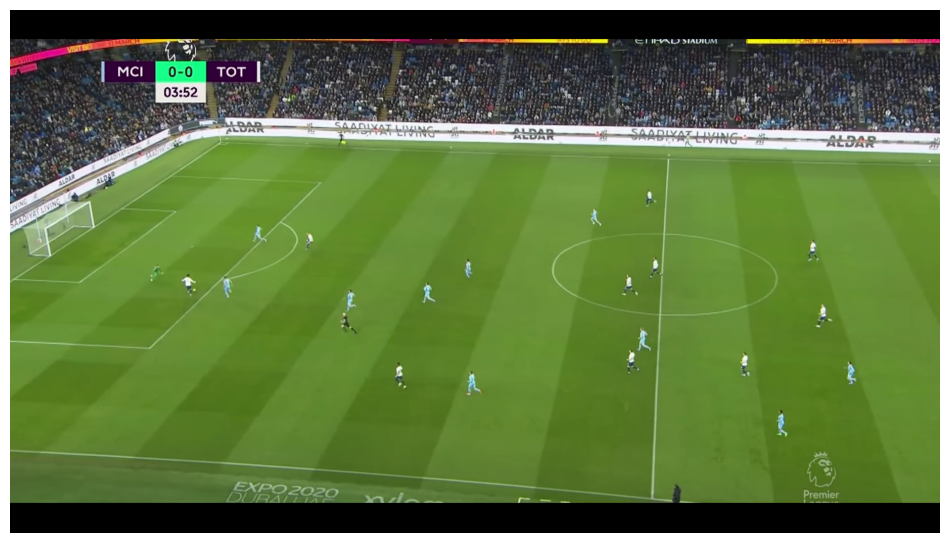

In [10]:
import supervision as sv

SOURCE_VIDEO_PATH = "./data/videos/goal_1_cam_far.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)


0: 416x800 1 goalline, 14 players, 57.6ms
Speed: 4.0ms preprocess, 57.6ms inference, 112.5ms postprocess per image at shape (1, 3, 416, 800)


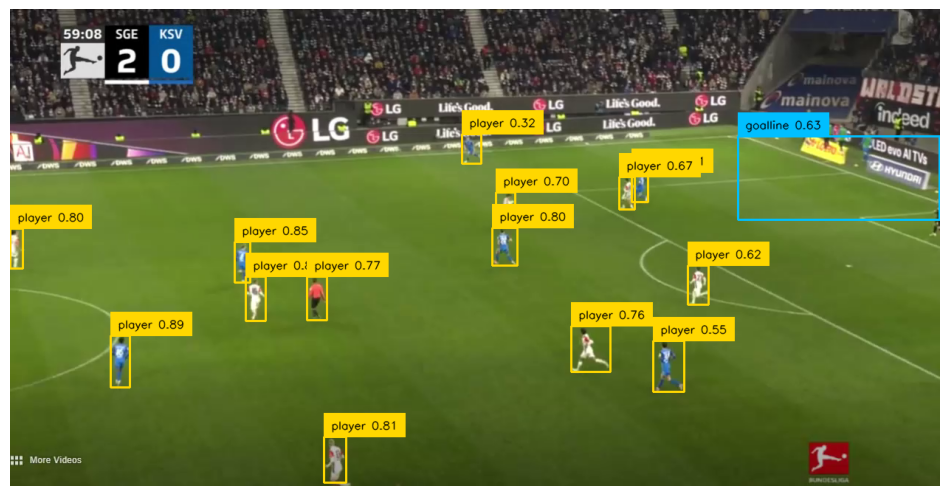

In [11]:
import supervision as sv

SOURCE_VIDEO_PATH = "./data/videos/v3.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

results = model(frame)[0]
detections = sv.Detections.from_ultralytics(results)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)


0: 416x800 1 goalline, 14 players, 25.8ms
Speed: 2.2ms preprocess, 25.8ms inference, 3.1ms postprocess per image at shape (1, 3, 416, 800)


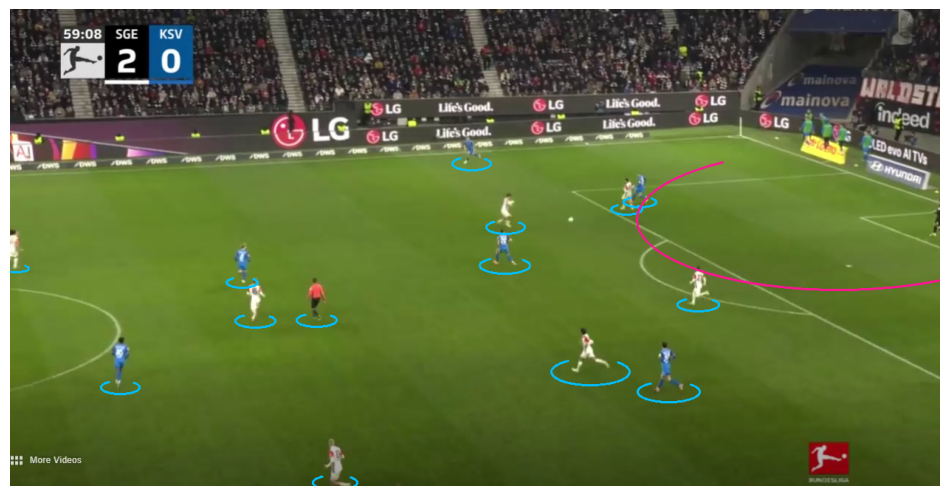

In [12]:
import supervision as sv

SOURCE_VIDEO_PATH = "./data/videos/v3.mp4"
BALL_ID = 1

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

results = model(frame)[0]
detections = sv.Detections.from_ultralytics(results)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)



0: 416x800 1 ball, 24.7ms
Speed: 2.3ms preprocess, 24.7ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 800)


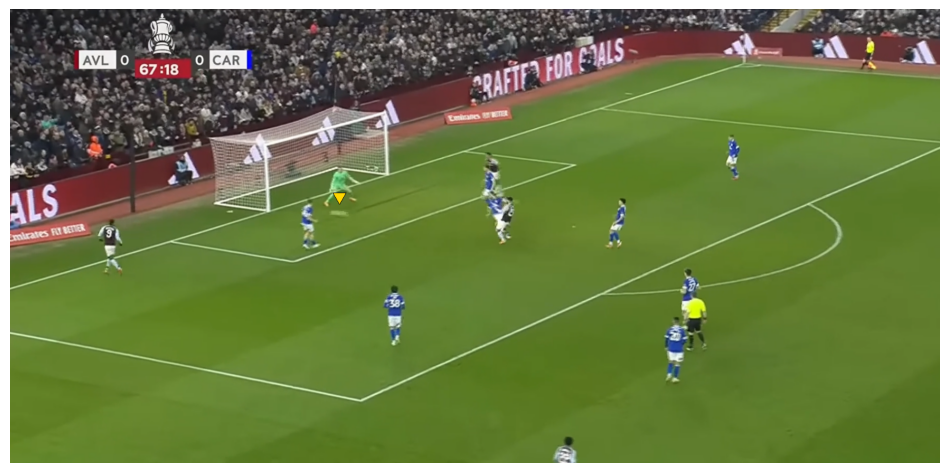

In [13]:
import cv2

image_path = "./data/images/img_2.png"  # replace with your image path
frame = cv2.imread(image_path)

# Perform detection
results = model(frame)[0]

# Convert to Supervision Detections
detections = sv.Detections.from_ultralytics(results)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

annotated_frame = triangle_annotator.annotate(
    scene=frame.copy(),
    detections=ball_detections)

sv.plot_image(annotated_frame)





0: 416x800 1 goalline, 14 players, 24.4ms
Speed: 2.1ms preprocess, 24.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 800)


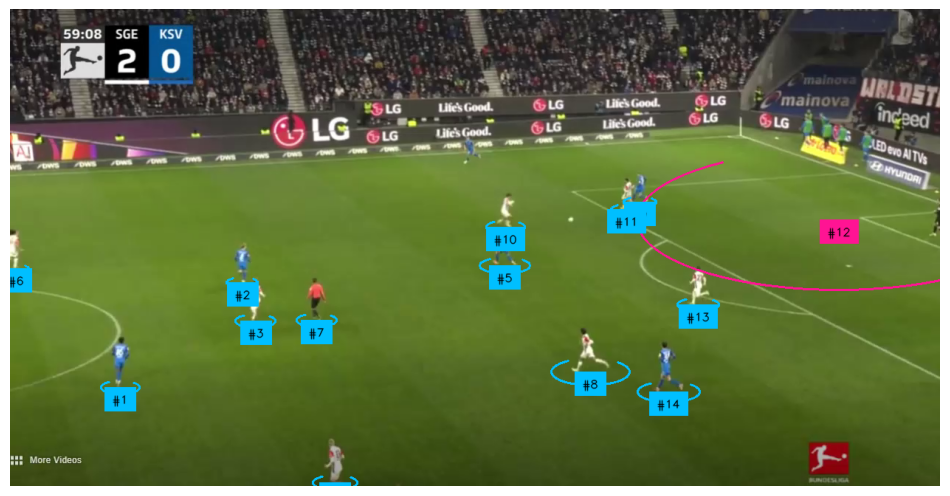

In [14]:
import supervision as sv

SOURCE_VIDEO_PATH = "./data/videos/v3.mp4"
BALL_ID = 1

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

results = model(frame)[0]
detections = sv.Detections.from_ultralytics(results)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [15]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "./data/videos/v3.mp4"
PLAYER_ID = 7
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 0it [00:00, ?it/s]


0: 416x800 1 goalline, 14 players, 25.6ms
Speed: 2.6ms preprocess, 25.6ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 800)

0: 416x800 1 goalkeeper, 1 goalline, 14 players, 1 referee, 24.5ms
Speed: 2.4ms preprocess, 24.5ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 800)


collecting crops: 2it [00:00, 12.47it/s]


0: 416x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 1 referee, 25.2ms
Speed: 5.4ms preprocess, 25.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 800)

0: 416x800 1 goal, 1 goalline, 3 players, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 800)


collecting crops: 4it [00:00, 14.88it/s]


0: 416x800 1 goal, 1 goalline, 4 players, 25.8ms
Speed: 2.3ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 800)


collecting crops: 5it [00:00, 14.38it/s]


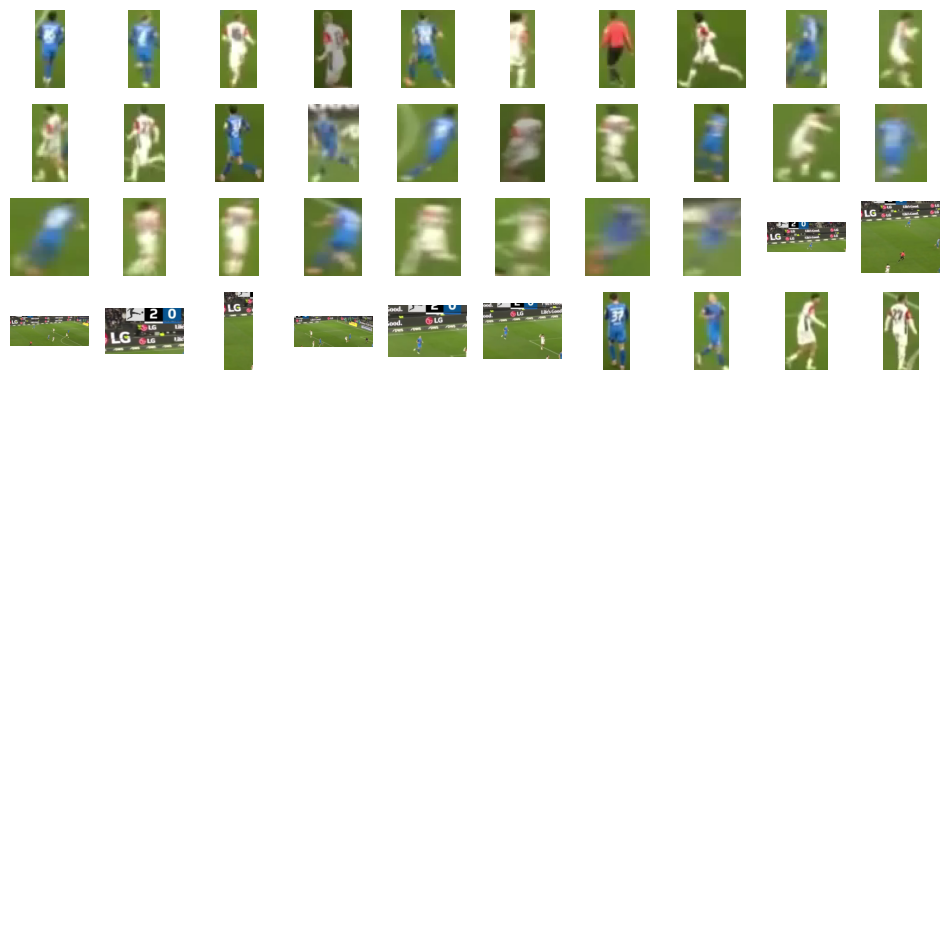

In [16]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))


**Note:** Next, we'll run [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) to calculate embeddings for each of the crops.

**Note:** Next, we'll run [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) to calculate embeddings for each of the crops.


**Note:** Next, we'll run [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) to calculate embeddings for each of the crops.

**Note:** Next, we'll run [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) to calculate embeddings for each of the crops.

In [17]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [18]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("CUDA current device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. Please check your CUDA installation and GPU setup.")

CUDA available: True
CUDA device count: 1
CUDA current device: 0
CUDA device name: NVIDIA GeForce RTX 4070 Laptop GPU


In [19]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 2it [00:00,  3.01it/s]


In [20]:
!pip install umap-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
from umap.umap_ import UMAP  # Correct import (note the `umap_` submodule)
from sklearn.cluster import KMeans

REDUCER = UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [22]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [23]:
!pip install plotly
!pip install plotly --upgrade

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/02/65/ad2bc85f7377f5cfba5d4466d5474423a3fb7f6a97fd807c06f92dd3e721/plotly-6.0.1-py3-none-any.whl.metadata
  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Obtaining dependency information for narwhals>=1.15.1 from https://files.pythonhosted.org/packages/b0/a2/2ea3f2058ae661b06fad1a14c0f29f1cc8e49478d02a2d68f0eac3872b86/narwhals-1.34.1-py3-none-any.whl.metadata
Using cached plotly-6.0.1-py3-none-any.whl (14.8 MB)
   ---------------------------------------- 0.0/325.5 kB ? eta -:--:--
   --------------------------------------- 325.5/325.5 kB 10.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "./data/videos/v1.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = model.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 21 players, 291.4ms
Speed: 11.2ms preprocess, 291.4ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 1it [00:00,  2.31it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 48.2ms
Speed: 8.8ms preprocess, 48.2ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 2it [00:00,  3.99it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 29.4ms
Speed: 7.5ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 1 referee, 34.2ms
Speed: 10.3ms preprocess, 34.2ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 4it [00:00,  6.32it/s]


0: 480x800 20 players, 1 referee, 57.8ms
Speed: 11.1ms preprocess, 57.8ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 5it [00:00,  6.44it/s]


0: 480x800 21 players, 1 referee, 44.7ms
Speed: 14.2ms preprocess, 44.7ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 6it [00:01,  6.51it/s]


0: 480x800 20 players, 1 referee, 42.9ms
Speed: 13.3ms preprocess, 42.9ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 7it [00:01,  6.43it/s]


0: 480x800 1 ball, 21 players, 46.2ms
Speed: 14.0ms preprocess, 46.2ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 8it [00:01,  6.50it/s]


0: 480x800 1 goalkeeper, 21 players, 45.7ms
Speed: 11.2ms preprocess, 45.7ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 9it [00:01,  6.55it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 37.2ms
Speed: 9.0ms preprocess, 37.2ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 10it [00:01,  7.00it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 20 players, 1 referee, 43.1ms
Speed: 11.9ms preprocess, 43.1ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 11it [00:01,  6.90it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 49.7ms
Speed: 12.1ms preprocess, 49.7ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 12it [00:01,  6.90it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 38.1ms
Speed: 9.8ms preprocess, 38.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 13it [00:02,  7.19it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 34.5ms
Speed: 10.9ms preprocess, 34.5ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 14it [00:02,  7.34it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 37.8ms
Speed: 11.0ms preprocess, 37.8ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 15it [00:02,  7.39it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 41.7ms
Speed: 10.5ms preprocess, 41.7ms inference, 7.4ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 16it [00:02,  7.27it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 53.3ms
Speed: 11.6ms preprocess, 53.3ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 17it [00:02,  6.88it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 41.0ms
Speed: 16.3ms preprocess, 41.0ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 18it [00:02,  6.43it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 57.1ms
Speed: 15.9ms preprocess, 57.1ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 19it [00:03,  5.97it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 44.2ms
Speed: 14.0ms preprocess, 44.2ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 20it [00:03,  6.06it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 47.8ms
Speed: 14.0ms preprocess, 47.8ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 21it [00:03,  6.15it/s]


0: 480x800 1 goalline, 20 players, 1 referee, 43.2ms
Speed: 15.6ms preprocess, 43.2ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 22it [00:03,  6.41it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 42.5ms
Speed: 10.3ms preprocess, 42.5ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 23it [00:03,  6.66it/s]


0: 480x800 1 goalline, 20 players, 1 referee, 45.6ms
Speed: 14.3ms preprocess, 45.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 24it [00:03,  6.55it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 42.4ms
Speed: 11.1ms preprocess, 42.4ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 800)


collecting crops: 25it [00:04,  6.24it/s]
Embedding extraction: 17it [00:04,  3.66it/s]


In [25]:
import numpy as np
import supervision as sv


def resolve_goalkeepers_team_id(
        players: sv.Detections,
        goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)



0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 21 players, 30.6ms
Speed: 6.8ms preprocess, 30.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)


Embedding extraction: 1it [00:00,  6.03it/s]


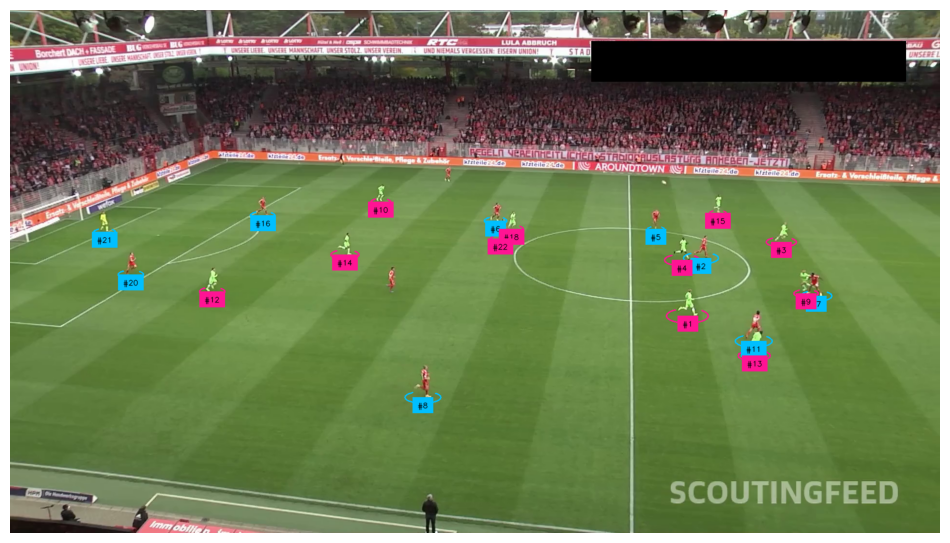

In [26]:
import supervision as sv

SOURCE_VIDEO_PATH = "./data/videos/v1.mp4"
BALL_ID = 1
GOALKEEPER_ID = 4
PLAYER_ID = 7
REFEREE_ID = 8

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = model.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)


In [27]:
field_detection_model = YOLO("./models/yolo8n-pose2.pt")



0: 416x800 1 pitch, 68.3ms
Speed: 3.8ms preprocess, 68.3ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 800)


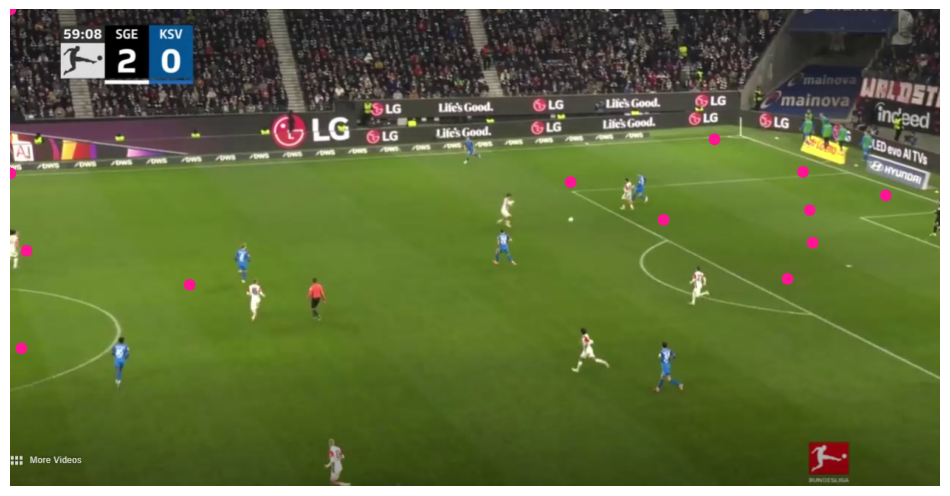

In [28]:
SOURCE_VIDEO_PATH = "./data/videos/v3.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = field_detection_model.predict(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)



0: 416x800 1 pitch, 23.5ms
Speed: 3.6ms preprocess, 23.5ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 800)


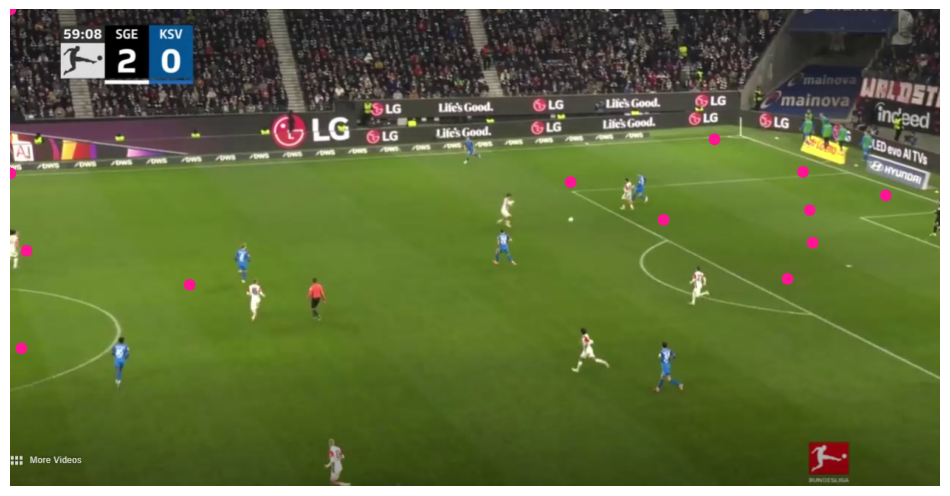

In [29]:
SOURCE_VIDEO_PATH = "./data/videos/v3.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = field_detection_model.predict(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

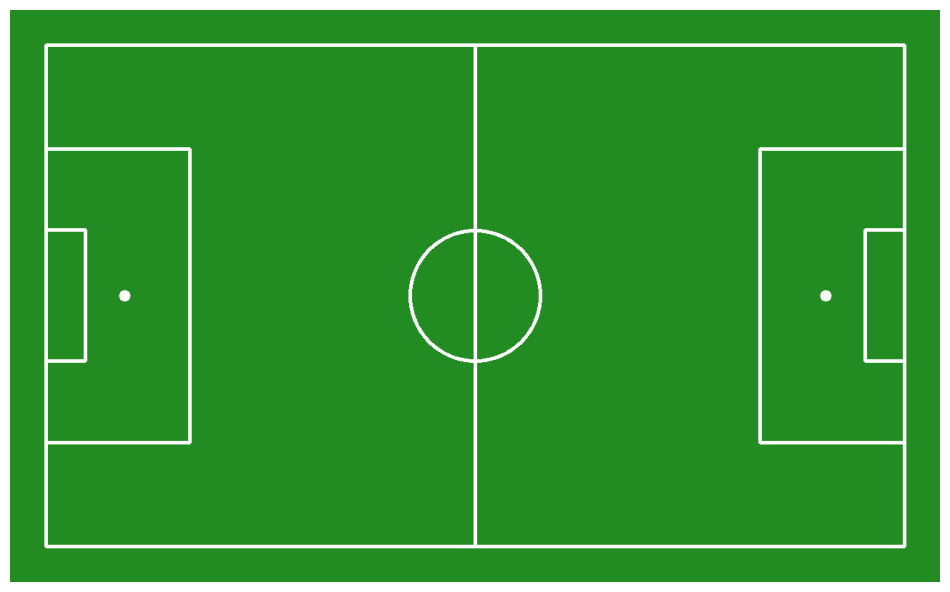

In [30]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)


0: 480x800 1 pitch, 78.5ms
Speed: 7.4ms preprocess, 78.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)


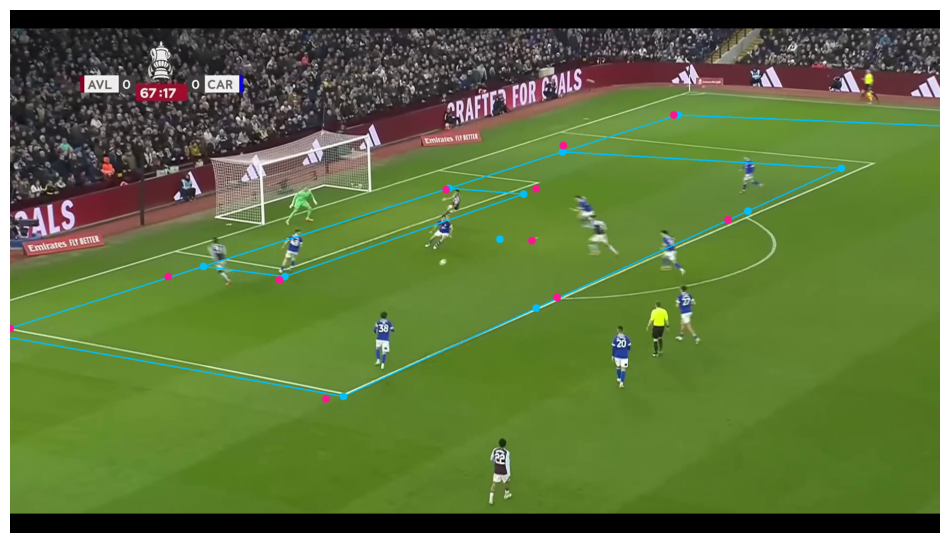

In [31]:
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "./data/videos/goal_2.mp4"

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=10)
frame = next(frame_generator)

result = field_detection_model.predict(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [32]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "./data/videos/v3.mp4"
PLAYER_ID = 7
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = model.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]


0: 416x800 1 goalline, 14 players, 369.2ms
Speed: 3.5ms preprocess, 369.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 800)


collecting crops: 1it [00:00,  2.38it/s]


0: 416x800 1 goalkeeper, 1 goalline, 14 players, 1 referee, 25.1ms
Speed: 2.4ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 800)

0: 416x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 1 referee, 25.2ms
Speed: 2.5ms preprocess, 25.2ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 800)


collecting crops: 3it [00:00,  6.75it/s]


0: 416x800 1 goal, 1 goalline, 3 players, 23.8ms
Speed: 2.7ms preprocess, 23.8ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 800)

0: 416x800 1 goal, 1 goalline, 4 players, 23.9ms
Speed: 2.8ms preprocess, 23.9ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 800)


collecting crops: 5it [00:00,  7.45it/s]
Embedding extraction: 2it [00:00,  3.33it/s]


In [33]:
import cv2
from typing import Optional


def draw_pitch_voronoi_diagram_2(
        config: SoccerPitchConfiguration,
        team_1_xy: np.ndarray,
        team_2_xy: np.ndarray,
        team_1_color: sv.Color = sv.Color.RED,
        team_2_color: sv.Color = sv.Color.WHITE,
        opacity: float = 0.5,
        padding: int = 50,
        scale: float = 0.1,
        pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay



0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 21 players, 26.9ms
Speed: 5.8ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)


Embedding extraction: 1it [00:00,  7.47it/s]


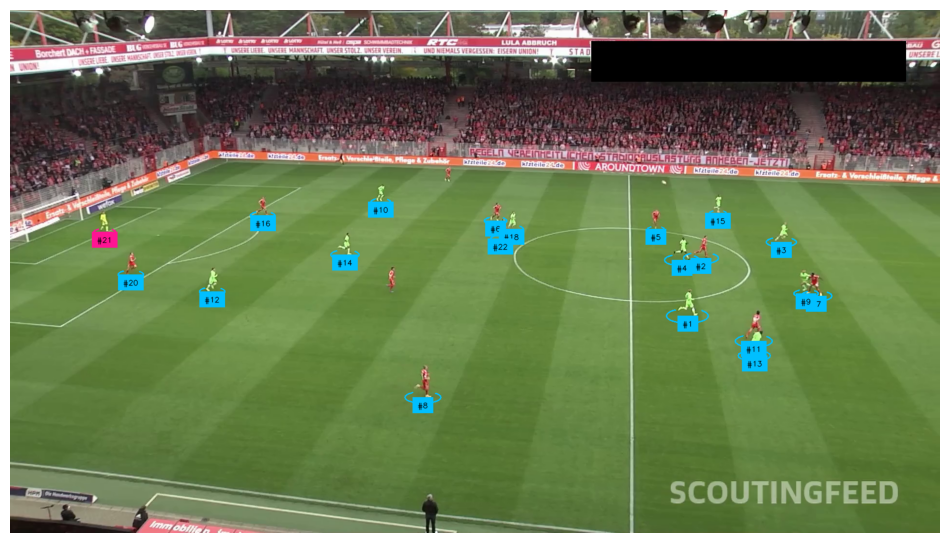


0: 480x800 1 pitch, 10.2ms
Speed: 3.2ms preprocess, 10.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


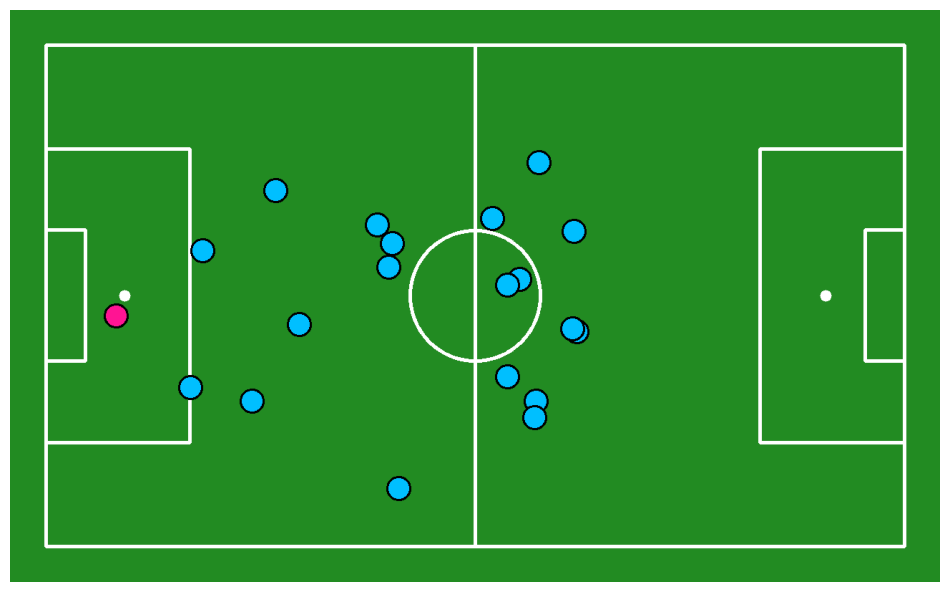

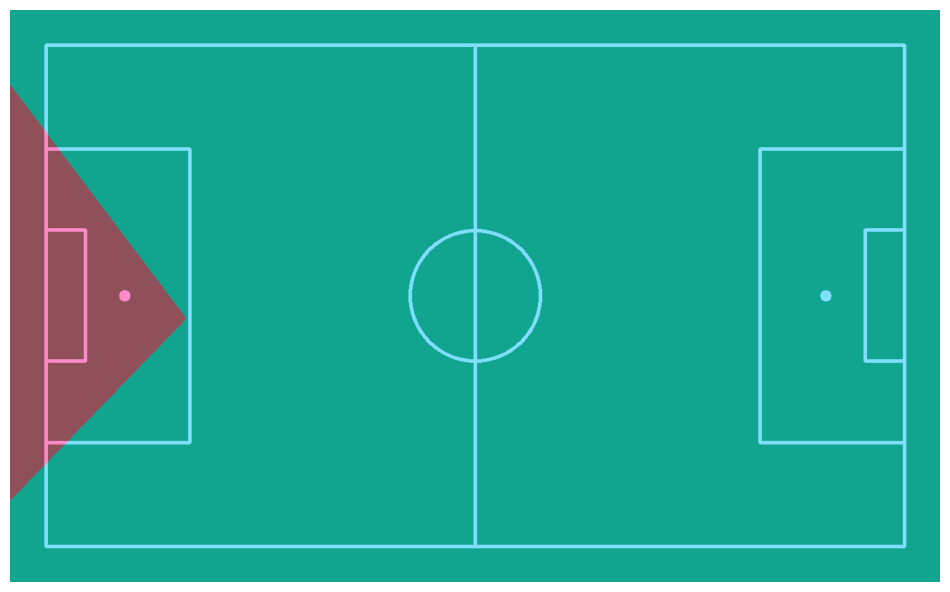

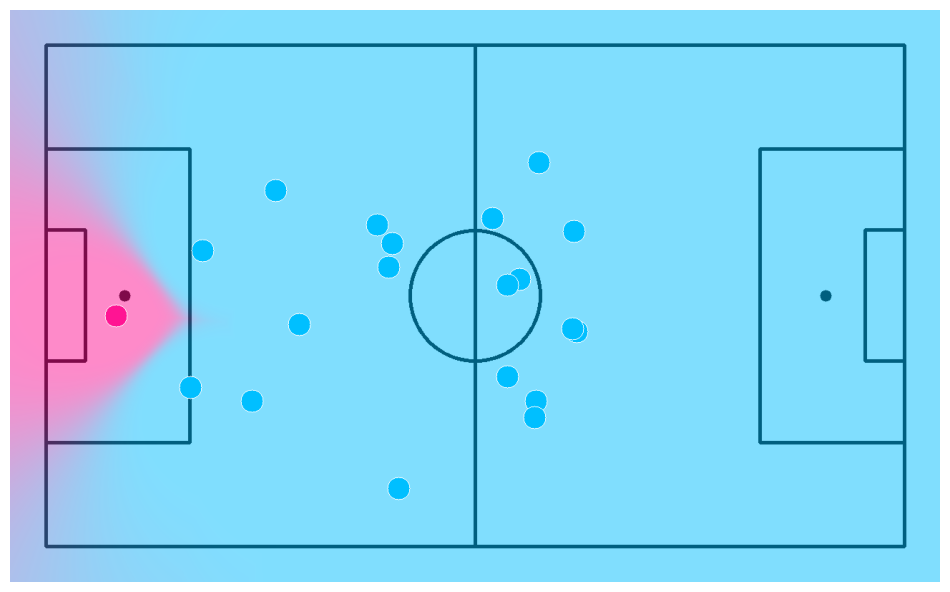

In [34]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "./data/videos/v1.mp4"
BALL_ID = 1
GOALKEEPER_ID = 4
PLAYER_ID = 7
REFEREE_ID = 8

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = model.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points

result = field_detection_model.predict(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# visualize video game-style radar view

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram with blend

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)


In [35]:
from collections import deque
import supervision as sv
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOURCE_VIDEO_PATH = "./data/videos/v1.mp4"
BALL_ID = 1
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = model.predict(frame, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = field_detection_model.predict(frame, conf=0.3)[0]
    key_points = sv.KeyPoints.from_ultralytics(result)

    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    path_raw.append(pitch_ball_xy)


  0%|          | 0/750 [00:00<?, ?it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 21 players, 101.7ms
Speed: 5.0ms preprocess, 101.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 4.1ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  0%|          | 1/750 [00:00<02:42,  4.62it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 21 players, 101.9ms
Speed: 3.9ms preprocess, 101.9ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.9ms
Speed: 3.9ms preprocess, 10.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


  0%|          | 2/750 [00:00<02:08,  5.83it/s]


0: 480x800 1 goalline, 19 players, 28.9ms
Speed: 3.8ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 4.2ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 29.6ms
Speed: 4.0ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.0ms
Speed: 3.9ms preprocess, 11.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


  1%|          | 4/750 [00:00<01:21,  9.20it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 28.7ms
Speed: 4.1ms preprocess, 28.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.8ms
Speed: 4.1ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 18 players, 28.3ms
Speed: 3.9ms preprocess, 28.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 3.9ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)


  1%|          | 6/750 [00:00<01:06, 11.20it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 28.1ms
Speed: 4.1ms preprocess, 28.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.1ms
Speed: 4.7ms preprocess, 11.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 20 players, 28.0ms
Speed: 3.9ms preprocess, 28.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 3.9ms preprocess, 11.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


  1%|          | 8/750 [00:00<00:59, 12.43it/s]


0: 480x800 1 goalkeeper, 1 goalline, 20 players, 25.3ms
Speed: 4.1ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 4.2ms preprocess, 11.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 25.3ms
Speed: 4.2ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.8ms
Speed: 4.1ms preprocess, 10.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


  1%|▏         | 10/750 [00:00<00:55, 13.27it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 20 players, 25.3ms
Speed: 4.2ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 1 goalline, 21 players, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


  2%|▏         | 12/750 [00:01<00:54, 13.62it/s]


0: 480x800 1 goalkeeper, 1 goalline, 21 players, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.5ms
Speed: 4.1ms preprocess, 20.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 25.5ms
Speed: 4.5ms preprocess, 25.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.0ms
Speed: 4.3ms preprocess, 15.0ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)


  2%|▏         | 14/750 [00:01<00:53, 13.71it/s]


0: 480x800 1 ball, 1 goalline, 18 players, 25.9ms
Speed: 4.1ms preprocess, 25.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 3.9ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 18 players, 1 referee, 24.7ms
Speed: 3.9ms preprocess, 24.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.3ms
Speed: 4.0ms preprocess, 18.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  2%|▏         | 16/750 [00:01<00:52, 14.02it/s]


0: 480x800 1 ball, 1 goal, 19 players, 1 referee, 24.7ms
Speed: 4.3ms preprocess, 24.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 5.4ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 22 players, 1 referee, 25.4ms
Speed: 4.5ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.8ms
Speed: 3.9ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)


  2%|▏         | 18/750 [00:01<00:50, 14.37it/s]


0: 480x800 22 players, 1 referee, 24.2ms
Speed: 4.1ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.7ms
Speed: 4.1ms preprocess, 10.7ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 22 players, 1 referee, 24.7ms
Speed: 4.3ms preprocess, 24.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.8ms
Speed: 3.9ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)


  3%|▎         | 20/750 [00:01<00:49, 14.84it/s]


0: 480x800 1 goal, 22 players, 24.4ms
Speed: 4.0ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.9ms
Speed: 4.1ms preprocess, 10.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 22 players, 24.6ms
Speed: 4.0ms preprocess, 24.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.3ms
Speed: 4.2ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  3%|▎         | 22/750 [00:01<00:48, 14.98it/s]


0: 480x800 1 ball, 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.1ms
Speed: 4.1ms preprocess, 24.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 3.9ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 2 goals, 1 goalkeeper, 20 players, 25.2ms
Speed: 4.0ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.2ms
Speed: 4.0ms preprocess, 10.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)


  3%|▎         | 24/750 [00:01<00:47, 15.40it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.1ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 25.4ms
Speed: 3.9ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.5ms
Speed: 3.7ms preprocess, 10.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


  3%|▎         | 26/750 [00:01<00:47, 15.32it/s]


0: 480x800 1 goal, 1 goalkeeper, 21 players, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 3.8ms preprocess, 11.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 2 goals, 1 goalkeeper, 20 players, 1 referee, 24.2ms
Speed: 5.1ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.7ms
Speed: 5.3ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  4%|▎         | 28/750 [00:02<00:46, 15.50it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 24.2ms
Speed: 3.9ms preprocess, 24.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.6ms
Speed: 3.7ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 26.0ms
Speed: 3.9ms preprocess, 26.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.5ms
Speed: 4.0ms preprocess, 19.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)


  4%|▍         | 30/750 [00:02<00:46, 15.39it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.2ms
Speed: 3.8ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.3ms
Speed: 4.3ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.8ms
Speed: 3.7ms preprocess, 24.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.4ms
Speed: 4.0ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)


  4%|▍         | 32/750 [00:02<00:46, 15.45it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 25.1ms
Speed: 4.7ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.0ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.0ms
Speed: 3.8ms preprocess, 24.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.6ms
Speed: 3.6ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


  5%|▍         | 34/750 [00:02<00:46, 15.29it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 26.0ms
Speed: 4.0ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 3.7ms preprocess, 12.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 25.4ms
Speed: 3.8ms preprocess, 25.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.2ms
Speed: 3.6ms preprocess, 10.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  5%|▍         | 36/750 [00:02<00:46, 15.45it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 25.2ms
Speed: 4.0ms preprocess, 25.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.4ms
Speed: 4.2ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.3ms
Speed: 3.7ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.0ms
Speed: 5.6ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  5%|▌         | 38/750 [00:02<00:45, 15.58it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 25.5ms
Speed: 4.0ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.3ms
Speed: 4.0ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 25.3ms
Speed: 3.8ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.4ms
Speed: 3.6ms preprocess, 10.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)


  5%|▌         | 40/750 [00:02<00:46, 15.43it/s]


0: 480x800 1 goal, 1 goalkeeper, 21 players, 1 referee, 25.0ms
Speed: 4.4ms preprocess, 25.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.6ms
Speed: 3.8ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 21 players, 1 referee, 25.6ms
Speed: 3.9ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.7ms
Speed: 4.0ms preprocess, 16.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


  6%|▌         | 42/750 [00:03<00:46, 15.28it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 25.7ms
Speed: 3.9ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 3.8ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 18 players, 1 referee, 25.2ms
Speed: 3.8ms preprocess, 25.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.3ms
Speed: 3.5ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  6%|▌         | 44/750 [00:03<00:45, 15.60it/s]


0: 480x800 1 goal, 1 goalkeeper, 21 players, 1 referee, 24.1ms
Speed: 4.0ms preprocess, 24.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.9ms
Speed: 4.2ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 21 players, 1 referee, 24.5ms
Speed: 4.1ms preprocess, 24.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.0ms
Speed: 3.7ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)


  6%|▌         | 46/750 [00:03<00:45, 15.47it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.2ms
Speed: 5.6ms preprocess, 24.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.7ms
Speed: 4.2ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 22 players, 25.0ms
Speed: 4.1ms preprocess, 25.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.3ms
Speed: 3.8ms preprocess, 10.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)


  6%|▋         | 48/750 [00:03<00:44, 15.77it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.8ms
Speed: 3.9ms preprocess, 24.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 4.1ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 25.1ms
Speed: 3.8ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.4ms
Speed: 4.0ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


  7%|▋         | 50/750 [00:03<00:45, 15.36it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 24.4ms
Speed: 4.2ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.8ms
Speed: 3.8ms preprocess, 10.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 21 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 4.3ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


  7%|▋         | 52/750 [00:03<00:44, 15.64it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.1ms
Speed: 4.1ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 5.9ms preprocess, 13.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.1ms
Speed: 4.3ms preprocess, 24.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.0ms
Speed: 4.3ms preprocess, 14.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


  7%|▋         | 54/750 [00:03<00:45, 15.13it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 24.3ms
Speed: 4.0ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.0ms preprocess, 12.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.0ms
Speed: 4.6ms preprocess, 24.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.6ms
Speed: 4.2ms preprocess, 16.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  7%|▋         | 56/750 [00:03<00:46, 14.84it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.3ms
Speed: 4.0ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.1ms
Speed: 4.0ms preprocess, 11.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.0ms
Speed: 3.9ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.9ms
Speed: 4.0ms preprocess, 10.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


  8%|▊         | 58/750 [00:04<00:45, 15.16it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 4.0ms preprocess, 11.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 25.0ms
Speed: 4.6ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.7ms
Speed: 4.0ms preprocess, 10.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


  8%|▊         | 60/750 [00:04<00:45, 15.09it/s]


0: 480x800 1 goal, 1 goalkeeper, 20 players, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.3ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 25.4ms
Speed: 5.2ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  8%|▊         | 62/750 [00:04<00:44, 15.37it/s]


0: 480x800 1 goal, 1 goalkeeper, 21 players, 24.1ms
Speed: 3.9ms preprocess, 24.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.1ms preprocess, 12.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 22 players, 24.9ms
Speed: 4.0ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.2ms
Speed: 4.0ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)


  9%|▊         | 64/750 [00:04<00:45, 15.24it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 26.0ms
Speed: 4.7ms preprocess, 26.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.4ms
Speed: 4.1ms preprocess, 10.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 19 players, 25.7ms
Speed: 4.0ms preprocess, 25.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.3ms
Speed: 4.0ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)


  9%|▉         | 66/750 [00:04<00:44, 15.22it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 24.2ms
Speed: 3.9ms preprocess, 24.2ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.8ms
Speed: 3.8ms preprocess, 10.8ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 24.9ms
Speed: 4.3ms preprocess, 24.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.6ms
Speed: 3.7ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


  9%|▉         | 68/750 [00:04<00:44, 15.37it/s]


0: 480x800 20 players, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.6ms
Speed: 4.2ms preprocess, 16.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 20 players, 25.9ms
Speed: 4.1ms preprocess, 25.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.3ms
Speed: 4.3ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)


  9%|▉         | 70/750 [00:04<00:44, 15.31it/s]


0: 480x800 21 players, 24.9ms
Speed: 4.1ms preprocess, 24.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.4ms
Speed: 4.8ms preprocess, 23.4ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 24.3ms
Speed: 4.9ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.6ms preprocess, 11.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


 10%|▉         | 72/750 [00:04<00:46, 14.61it/s]


0: 480x800 20 players, 24.2ms
Speed: 4.7ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.2ms preprocess, 11.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 23 players, 25.7ms
Speed: 4.2ms preprocess, 25.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.2ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 10%|▉         | 74/750 [00:05<00:45, 14.77it/s]


0: 480x800 1 goal, 20 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 19 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.0ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 10%|█         | 76/750 [00:05<00:45, 14.81it/s]


0: 480x800 1 goal, 19 players, 2 referees, 24.4ms
Speed: 4.2ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.1ms
Speed: 4.5ms preprocess, 11.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 19 players, 2 referees, 25.1ms
Speed: 4.5ms preprocess, 25.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.6ms
Speed: 4.2ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


 10%|█         | 78/750 [00:05<00:45, 14.92it/s]


0: 480x800 21 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 4.0ms preprocess, 11.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 24.6ms
Speed: 3.9ms preprocess, 24.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 10.8ms
Speed: 4.2ms preprocess, 10.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 11%|█         | 80/750 [00:05<00:44, 15.09it/s]


0: 480x800 21 players, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.2ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 24.1ms
Speed: 4.2ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 4.2ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 11%|█         | 82/750 [00:05<00:44, 15.13it/s]


0: 480x800 21 players, 24.1ms
Speed: 4.4ms preprocess, 24.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.1ms preprocess, 12.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 24.4ms
Speed: 4.2ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.0ms preprocess, 12.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 11%|█         | 84/750 [00:05<00:43, 15.17it/s]


0: 480x800 20 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.2ms preprocess, 11.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 20 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.6ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 11%|█▏        | 86/750 [00:05<00:44, 15.07it/s]


0: 480x800 1 goal, 20 players, 1 referee, 24.6ms
Speed: 4.1ms preprocess, 24.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.0ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 20 players, 1 referee, 26.1ms
Speed: 4.2ms preprocess, 26.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.2ms preprocess, 12.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 12%|█▏        | 88/750 [00:06<00:44, 15.04it/s]


0: 480x800 1 goal, 20 players, 1 referee, 25.8ms
Speed: 4.5ms preprocess, 25.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 5.3ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 21 players, 1 referee, 25.2ms
Speed: 4.9ms preprocess, 25.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.4ms
Speed: 4.1ms preprocess, 23.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 12%|█▏        | 90/750 [00:06<00:45, 14.40it/s]


0: 480x800 21 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.4ms
Speed: 4.3ms preprocess, 17.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.3ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 12%|█▏        | 92/750 [00:06<00:45, 14.52it/s]


0: 480x800 20 players, 1 referee, 24.5ms
Speed: 4.3ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.4ms preprocess, 12.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 25.2ms
Speed: 4.4ms preprocess, 25.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.0ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 13%|█▎        | 94/750 [00:06<00:45, 14.48it/s]


0: 480x800 20 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.4ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 25.1ms
Speed: 4.9ms preprocess, 25.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.4ms preprocess, 12.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 13%|█▎        | 96/750 [00:06<00:45, 14.41it/s]


0: 480x800 21 players, 1 referee, 24.6ms
Speed: 4.3ms preprocess, 24.6ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.5ms preprocess, 12.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.2ms preprocess, 12.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 13%|█▎        | 98/750 [00:06<00:45, 14.32it/s]


0: 480x800 20 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.0ms
Speed: 4.3ms preprocess, 14.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.1ms
Speed: 4.3ms preprocess, 24.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.2ms preprocess, 12.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 13%|█▎        | 100/750 [00:06<00:45, 14.38it/s]


0: 480x800 20 players, 1 referee, 24.1ms
Speed: 4.3ms preprocess, 24.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.7ms preprocess, 13.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.1ms
Speed: 4.6ms preprocess, 24.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.5ms preprocess, 13.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 14%|█▎        | 102/750 [00:07<00:45, 14.34it/s]


0: 480x800 20 players, 1 referee, 24.1ms
Speed: 5.7ms preprocess, 24.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.1ms preprocess, 13.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.6ms preprocess, 13.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 14%|█▍        | 104/750 [00:07<00:44, 14.36it/s]


0: 480x800 20 players, 1 referee, 24.2ms
Speed: 5.1ms preprocess, 24.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.4ms
Speed: 4.5ms preprocess, 14.4ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.9ms
Speed: 4.6ms preprocess, 24.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 5.6ms preprocess, 12.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 14%|█▍        | 106/750 [00:07<00:45, 14.19it/s]


0: 480x800 20 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.7ms
Speed: 4.2ms preprocess, 21.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.6ms
Speed: 4.8ms preprocess, 24.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.6ms
Speed: 4.4ms preprocess, 14.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 14%|█▍        | 108/750 [00:07<00:45, 14.01it/s]


0: 480x800 20 players, 1 referee, 24.2ms
Speed: 5.0ms preprocess, 24.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.6ms preprocess, 12.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.0ms
Speed: 4.6ms preprocess, 24.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.7ms
Speed: 4.9ms preprocess, 13.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 15%|█▍        | 110/750 [00:07<00:45, 14.04it/s]


0: 480x800 21 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.5ms preprocess, 13.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 15%|█▍        | 112/750 [00:07<00:45, 13.98it/s]


0: 480x800 20 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.3ms
Speed: 5.0ms preprocess, 17.3ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.7ms
Speed: 5.2ms preprocess, 24.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.6ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 15%|█▌        | 114/750 [00:07<00:46, 13.82it/s]


0: 480x800 20 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.1ms
Speed: 4.8ms preprocess, 16.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 25.1ms
Speed: 4.5ms preprocess, 25.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.5ms preprocess, 12.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 15%|█▌        | 116/750 [00:08<00:45, 13.95it/s]


0: 480x800 21 players, 24.7ms
Speed: 4.8ms preprocess, 24.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.3ms preprocess, 12.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 2 referees, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.9ms
Speed: 4.7ms preprocess, 13.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 16%|█▌        | 118/750 [00:08<00:45, 14.03it/s]


0: 480x800 20 players, 2 referees, 24.2ms
Speed: 4.7ms preprocess, 24.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.9ms preprocess, 13.4ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.7ms
Speed: 6.1ms preprocess, 24.7ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.3ms
Speed: 5.4ms preprocess, 15.3ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)


 16%|█▌        | 120/750 [00:08<00:45, 13.73it/s]


0: 480x800 20 players, 1 referee, 24.4ms
Speed: 6.2ms preprocess, 24.4ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.2ms
Speed: 4.9ms preprocess, 14.2ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.7ms
Speed: 4.9ms preprocess, 15.7ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)


 16%|█▋        | 122/750 [00:08<00:47, 13.35it/s]


0: 480x800 20 players, 1 referee, 24.4ms
Speed: 5.3ms preprocess, 24.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.3ms
Speed: 5.1ms preprocess, 14.3ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.3ms
Speed: 5.1ms preprocess, 24.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.9ms
Speed: 4.9ms preprocess, 13.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 17%|█▋        | 124/750 [00:08<00:46, 13.34it/s]


0: 480x800 20 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.7ms
Speed: 4.8ms preprocess, 13.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.8ms
Speed: 4.9ms preprocess, 24.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.8ms preprocess, 13.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 17%|█▋        | 126/750 [00:08<00:45, 13.62it/s]


0: 480x800 20 players, 1 referee, 24.4ms
Speed: 4.7ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.9ms
Speed: 4.5ms preprocess, 13.9ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.3ms
Speed: 5.3ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.5ms
Speed: 4.7ms preprocess, 15.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 17%|█▋        | 128/750 [00:08<00:45, 13.58it/s]


0: 480x800 21 players, 24.7ms
Speed: 4.8ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.0ms
Speed: 4.6ms preprocess, 14.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 1 referee, 24.7ms
Speed: 4.6ms preprocess, 24.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.8ms
Speed: 4.8ms preprocess, 15.8ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 17%|█▋        | 130/750 [00:09<00:45, 13.68it/s]


0: 480x800 20 players, 1 referee, 24.7ms
Speed: 4.8ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 25.0ms
Speed: 4.3ms preprocess, 25.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.3ms
Speed: 4.5ms preprocess, 14.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 18%|█▊        | 132/750 [00:09<00:44, 13.78it/s]


0: 480x800 1 ball, 20 players, 1 referee, 24.2ms
Speed: 4.9ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.3ms preprocess, 12.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 25.8ms
Speed: 5.7ms preprocess, 25.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.6ms
Speed: 4.5ms preprocess, 16.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 18%|█▊        | 134/750 [00:09<00:44, 13.79it/s]


0: 480x800 1 ball, 22 players, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.4ms preprocess, 13.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.6ms
Speed: 4.4ms preprocess, 14.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 18%|█▊        | 136/750 [00:09<00:44, 13.89it/s]


0: 480x800 1 ball, 19 players, 1 referee, 24.6ms
Speed: 5.2ms preprocess, 24.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.1ms
Speed: 4.6ms preprocess, 23.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 25.2ms
Speed: 4.7ms preprocess, 25.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.2ms
Speed: 7.1ms preprocess, 14.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 18%|█▊        | 138/750 [00:09<00:44, 13.66it/s]


0: 480x800 1 ball, 20 players, 24.9ms
Speed: 4.8ms preprocess, 24.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.0ms
Speed: 4.8ms preprocess, 21.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 19 players, 1 referee, 25.4ms
Speed: 4.6ms preprocess, 25.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.2ms
Speed: 4.9ms preprocess, 16.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 19%|█▊        | 140/750 [00:09<00:45, 13.48it/s]


0: 480x800 19 players, 1 referee, 25.4ms
Speed: 5.0ms preprocess, 25.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.4ms
Speed: 4.6ms preprocess, 14.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 19 players, 1 referee, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.8ms
Speed: 4.4ms preprocess, 16.8ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)


 19%|█▉        | 142/750 [00:09<00:45, 13.34it/s]


0: 480x800 20 players, 1 referee, 25.8ms
Speed: 5.1ms preprocess, 25.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.5ms preprocess, 12.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 25.0ms
Speed: 4.5ms preprocess, 25.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.4ms preprocess, 13.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 19%|█▉        | 144/750 [00:10<00:44, 13.60it/s]


0: 480x800 1 ball, 20 players, 1 referee, 25.3ms
Speed: 4.4ms preprocess, 25.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.2ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 25.2ms
Speed: 5.1ms preprocess, 25.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 5.2ms preprocess, 13.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 19%|█▉        | 146/750 [00:10<00:43, 13.74it/s]


0: 480x800 1 ball, 21 players, 1 referee, 25.0ms
Speed: 4.4ms preprocess, 25.0ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.9ms
Speed: 4.6ms preprocess, 24.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.9ms
Speed: 4.2ms preprocess, 14.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 20%|█▉        | 148/750 [00:10<00:42, 14.06it/s]


0: 480x800 1 ball, 20 players, 1 referee, 24.4ms
Speed: 4.9ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.5ms
Speed: 4.8ms preprocess, 15.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 25.3ms
Speed: 5.8ms preprocess, 25.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.8ms preprocess, 13.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 20%|██        | 150/750 [00:10<00:43, 13.70it/s]


0: 480x800 21 players, 1 referee, 24.5ms
Speed: 6.6ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.1ms
Speed: 4.5ms preprocess, 14.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 24.9ms
Speed: 4.6ms preprocess, 24.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.7ms preprocess, 13.8ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)


 20%|██        | 152/750 [00:10<00:43, 13.87it/s]


0: 480x800 1 ball, 19 players, 1 referee, 24.8ms
Speed: 4.6ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.7ms preprocess, 13.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 19 players, 1 referee, 25.1ms
Speed: 4.9ms preprocess, 25.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.4ms preprocess, 12.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 21%|██        | 154/750 [00:10<00:43, 13.77it/s]


0: 480x800 20 players, 1 referee, 25.1ms
Speed: 4.9ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.0ms
Speed: 4.7ms preprocess, 18.0ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 24.9ms
Speed: 4.6ms preprocess, 24.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.7ms preprocess, 12.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 21%|██        | 156/750 [00:10<00:43, 13.68it/s]


0: 480x800 19 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.5ms preprocess, 13.8ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 25.6ms
Speed: 5.4ms preprocess, 25.6ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.6ms preprocess, 13.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 21%|██        | 158/750 [00:11<00:43, 13.72it/s]


0: 480x800 21 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.1ms
Speed: 4.1ms preprocess, 14.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 1 referee, 25.3ms
Speed: 5.1ms preprocess, 25.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.4ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 21%|██▏       | 160/750 [00:11<00:42, 13.84it/s]


0: 480x800 1 ball, 1 goalkeeper, 22 players, 1 referee, 25.7ms
Speed: 4.4ms preprocess, 25.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.3ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 22 players, 1 referee, 25.4ms
Speed: 4.3ms preprocess, 25.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 22%|██▏       | 162/750 [00:11<00:41, 14.02it/s]


0: 480x800 1 ball, 20 players, 1 referee, 24.9ms
Speed: 4.7ms preprocess, 24.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.3ms preprocess, 13.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 24.7ms
Speed: 5.0ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.6ms preprocess, 12.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 22%|██▏       | 164/750 [00:11<00:41, 14.17it/s]


0: 480x800 1 ball, 20 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.6ms preprocess, 13.6ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 19 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.2ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 22%|██▏       | 166/750 [00:11<00:40, 14.36it/s]


0: 480x800 1 ball, 19 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.7ms preprocess, 12.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 19 players, 1 referee, 24.7ms
Speed: 4.3ms preprocess, 24.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.3ms preprocess, 13.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 22%|██▏       | 168/750 [00:11<00:40, 14.27it/s]


0: 480x800 1 ball, 21 players, 1 referee, 24.7ms
Speed: 5.3ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 24.5ms
Speed: 5.1ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.5ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 23%|██▎       | 170/750 [00:11<00:40, 14.28it/s]


0: 480x800 1 ball, 20 players, 1 referee, 24.6ms
Speed: 4.6ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.3ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 24.7ms
Speed: 4.3ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.5ms
Speed: 5.1ms preprocess, 19.5ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)


 23%|██▎       | 172/750 [00:12<00:40, 14.11it/s]


0: 480x800 22 players, 1 referee, 25.2ms
Speed: 4.4ms preprocess, 25.2ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.8ms preprocess, 13.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 23%|██▎       | 174/750 [00:12<00:40, 14.30it/s]


0: 480x800 20 players, 1 referee, 28.1ms
Speed: 4.8ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.3ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.5ms preprocess, 12.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 23%|██▎       | 176/750 [00:12<00:40, 14.23it/s]


0: 480x800 20 players, 1 referee, 24.6ms
Speed: 4.9ms preprocess, 24.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 29.9ms
Speed: 4.6ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.4ms preprocess, 12.8ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 24%|██▎       | 178/750 [00:12<00:41, 13.88it/s]


0: 480x800 20 players, 1 referee, 26.1ms
Speed: 4.8ms preprocess, 26.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.2ms preprocess, 13.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.8ms
Speed: 4.5ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.5ms
Speed: 4.4ms preprocess, 18.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 24%|██▍       | 180/750 [00:12<00:41, 13.85it/s]


0: 480x800 20 players, 1 referee, 24.9ms
Speed: 4.4ms preprocess, 24.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 1 referee, 25.2ms
Speed: 4.5ms preprocess, 25.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.5ms preprocess, 11.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 24%|██▍       | 182/750 [00:12<00:40, 14.08it/s]


0: 480x800 19 players, 1 referee, 25.0ms
Speed: 5.3ms preprocess, 25.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.6ms preprocess, 12.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 24.7ms
Speed: 4.4ms preprocess, 24.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.2ms preprocess, 12.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 25%|██▍       | 184/750 [00:12<00:39, 14.47it/s]


0: 480x800 20 players, 1 referee, 24.7ms
Speed: 5.3ms preprocess, 24.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.9ms preprocess, 13.6ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.0ms
Speed: 4.4ms preprocess, 20.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 25%|██▍       | 186/750 [00:13<00:40, 14.00it/s]


0: 480x800 21 players, 1 referee, 24.8ms
Speed: 4.6ms preprocess, 24.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.4ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 24.2ms
Speed: 4.9ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.5ms preprocess, 12.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 25%|██▌       | 188/750 [00:13<00:40, 13.97it/s]


0: 480x800 20 players, 1 referee, 25.4ms
Speed: 5.0ms preprocess, 25.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.4ms preprocess, 11.9ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 24.5ms
Speed: 4.8ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.0ms
Speed: 4.6ms preprocess, 15.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


 25%|██▌       | 190/750 [00:13<00:39, 14.02it/s]


0: 480x800 1 ball, 20 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.8ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 24.9ms
Speed: 4.6ms preprocess, 24.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.3ms preprocess, 12.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 26%|██▌       | 192/750 [00:13<00:39, 14.02it/s]


0: 480x800 19 players, 1 referee, 24.7ms
Speed: 4.6ms preprocess, 24.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.2ms preprocess, 12.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.7ms
Speed: 4.6ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.1ms preprocess, 12.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 26%|██▌       | 194/750 [00:13<00:39, 14.18it/s]


0: 480x800 18 players, 1 referee, 25.4ms
Speed: 5.5ms preprocess, 25.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.5ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 22 players, 25.1ms
Speed: 4.3ms preprocess, 25.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.5ms preprocess, 13.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 26%|██▌       | 196/750 [00:13<00:38, 14.21it/s]


0: 480x800 22 players, 1 referee, 24.6ms
Speed: 4.7ms preprocess, 24.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 24.9ms
Speed: 4.6ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.3ms preprocess, 12.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 26%|██▋       | 198/750 [00:13<00:38, 14.16it/s]


0: 480x800 19 players, 1 referee, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.4ms
Speed: 4.9ms preprocess, 19.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.7ms
Speed: 4.6ms preprocess, 14.7ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 27%|██▋       | 200/750 [00:14<00:39, 14.04it/s]


0: 480x800 1 ball, 19 players, 1 referee, 24.8ms
Speed: 4.7ms preprocess, 24.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.7ms
Speed: 4.3ms preprocess, 13.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 1 referee, 24.8ms
Speed: 4.4ms preprocess, 24.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.5ms
Speed: 4.5ms preprocess, 14.5ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 27%|██▋       | 202/750 [00:14<00:39, 13.95it/s]


0: 480x800 1 ball, 21 players, 1 referee, 24.7ms
Speed: 4.5ms preprocess, 24.7ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.4ms preprocess, 13.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 22 players, 1 referee, 24.9ms
Speed: 4.7ms preprocess, 24.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.5ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 27%|██▋       | 204/750 [00:14<00:38, 14.02it/s]


0: 480x800 1 ball, 20 players, 1 referee, 25.6ms
Speed: 6.0ms preprocess, 25.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.3ms
Speed: 4.3ms preprocess, 18.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 22 players, 1 referee, 25.4ms
Speed: 4.5ms preprocess, 25.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 27%|██▋       | 206/750 [00:14<00:38, 14.11it/s]


0: 480x800 1 ball, 19 players, 1 referee, 30.0ms
Speed: 4.6ms preprocess, 30.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 25.1ms
Speed: 4.3ms preprocess, 25.1ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 25.1ms
Speed: 4.8ms preprocess, 25.1ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 5.0ms preprocess, 13.8ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 800)


 28%|██▊       | 208/750 [00:14<00:40, 13.22it/s]


0: 480x800 1 ball, 18 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.4ms
Speed: 4.3ms preprocess, 16.4ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 18 players, 1 referee, 24.9ms
Speed: 4.7ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.4ms preprocess, 12.7ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 28%|██▊       | 210/750 [00:14<00:40, 13.33it/s]


0: 480x800 1 ball, 21 players, 25.0ms
Speed: 4.3ms preprocess, 25.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.2ms
Speed: 4.6ms preprocess, 23.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 24.9ms
Speed: 6.0ms preprocess, 24.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.3ms preprocess, 13.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 28%|██▊       | 212/750 [00:14<00:40, 13.31it/s]


0: 480x800 21 players, 24.3ms
Speed: 4.9ms preprocess, 24.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.6ms preprocess, 13.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.6ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 29%|██▊       | 214/750 [00:15<00:39, 13.55it/s]


0: 480x800 19 players, 1 referee, 25.2ms
Speed: 5.2ms preprocess, 25.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 19 players, 1 referee, 25.3ms
Speed: 4.6ms preprocess, 25.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.4ms preprocess, 12.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 29%|██▉       | 216/750 [00:15<00:39, 13.69it/s]


0: 480x800 20 players, 25.6ms
Speed: 4.5ms preprocess, 25.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.3ms preprocess, 12.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 1 referee, 24.3ms
Speed: 4.9ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 29%|██▉       | 218/750 [00:15<00:38, 13.93it/s]


0: 480x800 20 players, 24.9ms
Speed: 4.5ms preprocess, 24.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.5ms preprocess, 13.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 22 players, 24.5ms
Speed: 4.8ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.4ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 29%|██▉       | 220/750 [00:15<00:37, 14.19it/s]


0: 480x800 21 players, 24.9ms
Speed: 5.1ms preprocess, 24.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.6ms preprocess, 12.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 aerial_duel, 21 players, 1 referee, 24.6ms
Speed: 4.3ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 30%|██▉       | 222/750 [00:15<00:37, 14.15it/s]


0: 480x800 1 ball, 22 players, 24.8ms
Speed: 4.7ms preprocess, 24.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.4ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 21 players, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 5.5ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 30%|██▉       | 224/750 [00:15<00:36, 14.26it/s]


0: 480x800 1 ball, 21 players, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 21 players, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.2ms preprocess, 12.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 30%|███       | 226/750 [00:15<00:36, 14.27it/s]


0: 480x800 21 players, 25.5ms
Speed: 4.7ms preprocess, 25.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.5ms preprocess, 12.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 21 players, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.6ms preprocess, 12.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 30%|███       | 228/750 [00:16<00:36, 14.37it/s]


0: 480x800 1 ball, 21 players, 24.5ms
Speed: 4.7ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.7ms
Speed: 4.5ms preprocess, 14.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 21 players, 1 referee, 24.8ms
Speed: 4.7ms preprocess, 24.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 25.4ms
Speed: 4.6ms preprocess, 25.4ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 31%|███       | 230/750 [00:16<00:37, 13.84it/s]


0: 480x800 22 players, 24.8ms
Speed: 4.3ms preprocess, 24.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.2ms preprocess, 12.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 22 players, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.8ms preprocess, 13.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 31%|███       | 232/750 [00:16<00:36, 14.08it/s]


0: 480x800 21 players, 25.0ms
Speed: 4.7ms preprocess, 25.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.5ms
Speed: 4.6ms preprocess, 15.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 20 players, 24.4ms
Speed: 5.2ms preprocess, 24.4ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.8ms preprocess, 13.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 31%|███       | 234/750 [00:16<00:37, 13.73it/s]


0: 480x800 20 players, 2 referees, 25.4ms
Speed: 5.0ms preprocess, 25.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.7ms preprocess, 13.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 20 players, 1 referee, 25.1ms
Speed: 4.8ms preprocess, 25.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.5ms
Speed: 5.0ms preprocess, 23.5ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 800)


 31%|███▏      | 236/750 [00:16<00:37, 13.55it/s]


0: 480x800 1 ball, 1 goalkeeper, 20 players, 1 referee, 25.0ms
Speed: 4.8ms preprocess, 25.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.4ms preprocess, 13.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 1 goalkeeper, 19 players, 1 referee, 25.3ms
Speed: 4.9ms preprocess, 25.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.3ms preprocess, 12.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 32%|███▏      | 238/750 [00:16<00:38, 13.46it/s]


0: 480x800 1 ball, 1 goalkeeper, 20 players, 1 referee, 25.5ms
Speed: 4.5ms preprocess, 25.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.7ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 20 players, 1 referee, 24.8ms
Speed: 4.6ms preprocess, 24.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.3ms preprocess, 13.8ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 32%|███▏      | 240/750 [00:16<00:37, 13.68it/s]


0: 480x800 1 goalkeeper, 21 players, 26.6ms
Speed: 4.6ms preprocess, 26.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.4ms preprocess, 13.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 20 players, 1 referee, 24.5ms
Speed: 5.4ms preprocess, 24.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.4ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 32%|███▏      | 242/750 [00:17<00:36, 13.80it/s]


0: 480x800 1 goalkeeper, 20 players, 1 referee, 25.1ms
Speed: 4.4ms preprocess, 25.1ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 20 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.2ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 33%|███▎      | 244/750 [00:17<00:36, 14.01it/s]


0: 480x800 1 goalkeeper, 20 players, 1 referee, 24.8ms
Speed: 4.6ms preprocess, 24.8ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.2ms preprocess, 13.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 20 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 33%|███▎      | 246/750 [00:17<00:35, 14.08it/s]


0: 480x800 1 goalkeeper, 20 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.5ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 20 players, 1 referee, 28.0ms
Speed: 4.3ms preprocess, 28.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 33%|███▎      | 248/750 [00:17<00:34, 14.41it/s]


0: 480x800 1 goalkeeper, 20 players, 1 referee, 24.6ms
Speed: 4.6ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.5ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 20 players, 1 referee, 24.8ms
Speed: 4.5ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.4ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 33%|███▎      | 250/750 [00:17<00:35, 14.17it/s]


0: 480x800 1 goalkeeper, 20 players, 24.9ms
Speed: 5.7ms preprocess, 24.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.7ms preprocess, 12.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.3ms preprocess, 12.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 34%|███▎      | 252/750 [00:17<00:34, 14.34it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 24.6ms
Speed: 4.8ms preprocess, 24.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.2ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 20 players, 24.8ms
Speed: 4.4ms preprocess, 24.8ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.6ms preprocess, 12.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 34%|███▍      | 254/750 [00:17<00:34, 14.38it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.5ms preprocess, 12.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 20 players, 24.5ms
Speed: 4.7ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.1ms preprocess, 12.9ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)


 34%|███▍      | 256/750 [00:18<00:34, 14.51it/s]


0: 480x800 1 goalkeeper, 1 goalline, 21 players, 25.4ms
Speed: 4.4ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.4ms preprocess, 13.2ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 1 goalline, 21 players, 24.8ms
Speed: 4.6ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.2ms preprocess, 13.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 34%|███▍      | 258/750 [00:18<00:34, 14.35it/s]


0: 480x800 1 goalkeeper, 1 goalline, 21 players, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.3ms
Speed: 4.3ms preprocess, 11.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 1 goalline, 20 players, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.2ms preprocess, 11.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 35%|███▍      | 260/750 [00:18<00:33, 14.69it/s]


0: 480x800 1 goalkeeper, 1 goalline, 21 players, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.3ms preprocess, 12.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 21 players, 24.6ms
Speed: 5.0ms preprocess, 24.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.8ms
Speed: 4.4ms preprocess, 14.8ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 35%|███▍      | 262/750 [00:18<00:33, 14.47it/s]


0: 480x800 1 goalline, 17 players, 27.8ms
Speed: 4.7ms preprocess, 27.8ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 5.8ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 24.3ms
Speed: 5.1ms preprocess, 24.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.2ms preprocess, 12.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 35%|███▌      | 264/750 [00:18<00:34, 14.04it/s]


0: 480x800 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.4ms
Speed: 4.8ms preprocess, 25.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 5.1ms preprocess, 13.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 35%|███▌      | 266/750 [00:18<00:33, 14.34it/s]


0: 480x800 1 goal, 1 goalline, 21 players, 24.8ms
Speed: 5.8ms preprocess, 24.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.5ms preprocess, 13.0ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 21 players, 24.7ms
Speed: 4.4ms preprocess, 24.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.4ms preprocess, 12.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 36%|███▌      | 268/750 [00:18<00:34, 14.09it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 24.8ms
Speed: 4.6ms preprocess, 24.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.5ms
Speed: 4.6ms preprocess, 18.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.6ms preprocess, 24.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.9ms
Speed: 4.5ms preprocess, 15.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 36%|███▌      | 270/750 [00:19<00:34, 13.96it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 25.1ms
Speed: 4.7ms preprocess, 25.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.7ms preprocess, 13.4ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 5.4ms preprocess, 24.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.1ms
Speed: 4.6ms preprocess, 14.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 36%|███▋      | 272/750 [00:19<00:34, 14.02it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 24.9ms
Speed: 4.5ms preprocess, 24.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.7ms
Speed: 4.8ms preprocess, 13.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.8ms
Speed: 5.0ms preprocess, 25.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.8ms preprocess, 13.6ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 37%|███▋      | 274/750 [00:19<00:34, 13.66it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.7ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.6ms preprocess, 13.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.1ms
Speed: 5.6ms preprocess, 25.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.3ms preprocess, 13.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 37%|███▋      | 276/750 [00:19<00:34, 13.67it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.7ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 24.5ms
Speed: 5.2ms preprocess, 24.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 26.8ms
Speed: 4.7ms preprocess, 26.8ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 800)


 37%|███▋      | 278/750 [00:19<00:35, 13.36it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.9ms preprocess, 24.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.4ms preprocess, 12.7ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 25.2ms
Speed: 4.8ms preprocess, 25.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.9ms preprocess, 13.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 37%|███▋      | 280/750 [00:19<00:34, 13.64it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 25.0ms
Speed: 4.7ms preprocess, 25.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.9ms
Speed: 4.9ms preprocess, 14.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 25.1ms
Speed: 4.6ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.4ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 38%|███▊      | 282/750 [00:19<00:34, 13.76it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 25.8ms
Speed: 4.6ms preprocess, 25.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.6ms preprocess, 13.2ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.5ms
Speed: 4.8ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.7ms preprocess, 13.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 38%|███▊      | 284/750 [00:20<00:34, 13.62it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.7ms
Speed: 4.6ms preprocess, 24.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.6ms preprocess, 12.5ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 29.6ms
Speed: 9.3ms preprocess, 29.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.6ms
Speed: 7.8ms preprocess, 22.6ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)


 38%|███▊      | 286/750 [00:20<00:35, 12.94it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 32.0ms
Speed: 9.8ms preprocess, 32.0ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.3ms
Speed: 9.7ms preprocess, 23.3ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 26.9ms
Speed: 12.6ms preprocess, 26.9ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.5ms
Speed: 9.9ms preprocess, 22.5ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)


 38%|███▊      | 288/750 [00:20<00:40, 11.30it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.6ms
Speed: 9.0ms preprocess, 24.6ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 37.5ms
Speed: 10.7ms preprocess, 37.5ms inference, 11.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 31.7ms
Speed: 11.8ms preprocess, 31.7ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 57.9ms
Speed: 10.3ms preprocess, 57.9ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 800)


 39%|███▊      | 290/750 [00:20<00:49,  9.30it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 36.6ms
Speed: 12.9ms preprocess, 36.6ms inference, 7.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 34.9ms
Speed: 12.2ms preprocess, 34.9ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 41.0ms
Speed: 11.2ms preprocess, 41.0ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.8ms
Speed: 6.8ms preprocess, 19.8ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 800)


 39%|███▉      | 292/750 [00:21<00:53,  8.54it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 33.9ms
Speed: 8.6ms preprocess, 33.9ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.7ms
Speed: 6.8ms preprocess, 19.7ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 800)


 39%|███▉      | 293/750 [00:21<00:52,  8.73it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 47.3ms
Speed: 12.5ms preprocess, 47.3ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 31.9ms
Speed: 8.2ms preprocess, 31.9ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 800)


 39%|███▉      | 294/750 [00:21<00:55,  8.22it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 25.6ms
Speed: 12.0ms preprocess, 25.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 30.8ms
Speed: 6.7ms preprocess, 30.8ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 800)


 39%|███▉      | 295/750 [00:21<00:54,  8.31it/s]


0: 480x800 1 ball, 1 goal, 1 goalline, 19 players, 1 referee, 31.9ms
Speed: 13.1ms preprocess, 31.9ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.8ms
Speed: 6.8ms preprocess, 19.8ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 800)


 39%|███▉      | 296/750 [00:21<00:53,  8.43it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 6.7ms preprocess, 24.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.0ms
Speed: 5.7ms preprocess, 17.0ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 6.2ms preprocess, 24.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.0ms
Speed: 5.6ms preprocess, 17.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)


 40%|███▉      | 298/750 [00:21<00:48,  9.41it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.7ms
Speed: 5.8ms preprocess, 25.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.5ms
Speed: 5.2ms preprocess, 15.5ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 5.2ms preprocess, 24.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.1ms
Speed: 4.8ms preprocess, 15.1ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)


 40%|████      | 300/750 [00:21<00:43, 10.36it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 20 players, 1 referee, 27.4ms
Speed: 5.0ms preprocess, 27.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.8ms preprocess, 13.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 20 players, 1 referee, 28.2ms
Speed: 4.7ms preprocess, 28.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.6ms preprocess, 13.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 40%|████      | 302/750 [00:22<00:39, 11.22it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 21 players, 1 referee, 27.2ms
Speed: 7.6ms preprocess, 27.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.7ms preprocess, 13.6ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 18 players, 1 referee, 28.6ms
Speed: 4.8ms preprocess, 28.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.9ms preprocess, 13.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 41%|████      | 304/750 [00:22<00:38, 11.68it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 17 players, 1 referee, 27.6ms
Speed: 4.9ms preprocess, 27.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.7ms preprocess, 12.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 15 players, 1 referee, 27.6ms
Speed: 4.9ms preprocess, 27.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.5ms preprocess, 13.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 41%|████      | 306/750 [00:22<00:36, 12.21it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 16 players, 1 referee, 27.6ms
Speed: 4.6ms preprocess, 27.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.8ms
Speed: 4.8ms preprocess, 21.8ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 27.5ms
Speed: 4.5ms preprocess, 27.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.7ms
Speed: 4.4ms preprocess, 13.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 41%|████      | 308/750 [00:22<00:36, 12.22it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 26.2ms
Speed: 4.5ms preprocess, 26.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.2ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 15 players, 1 referee, 27.5ms
Speed: 4.6ms preprocess, 27.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 41%|████▏     | 310/750 [00:22<00:34, 12.73it/s]


0: 480x800 1 goal, 1 goalkeeper, 16 players, 1 referee, 26.3ms
Speed: 4.6ms preprocess, 26.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.4ms preprocess, 13.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 27.5ms
Speed: 4.5ms preprocess, 27.5ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.4ms preprocess, 12.0ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)


 42%|████▏     | 312/750 [00:22<00:34, 12.79it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 26.4ms
Speed: 4.6ms preprocess, 26.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 20 players, 1 referee, 26.1ms
Speed: 4.3ms preprocess, 26.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 42%|████▏     | 314/750 [00:22<00:32, 13.26it/s]


0: 480x800 1 goal, 18 players, 1 referee, 26.6ms
Speed: 4.4ms preprocess, 26.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.3ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 18 players, 1 referee, 26.0ms
Speed: 4.5ms preprocess, 26.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.3ms preprocess, 12.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 42%|████▏     | 316/750 [00:23<00:32, 13.43it/s]


0: 480x800 1 goal, 1 goalkeeper, 19 players, 1 referee, 24.9ms
Speed: 4.3ms preprocess, 24.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.2ms preprocess, 13.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 42%|████▏     | 318/750 [00:23<00:30, 13.94it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.7ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.1ms preprocess, 12.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.8ms
Speed: 4.4ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.5ms preprocess, 13.2ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)


 43%|████▎     | 320/750 [00:23<00:30, 13.98it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.7ms
Speed: 4.3ms preprocess, 25.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.9ms
Speed: 4.2ms preprocess, 15.9ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)


 43%|████▎     | 322/750 [00:23<00:31, 13.73it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.9ms
Speed: 4.5ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.9ms
Speed: 4.4ms preprocess, 13.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.7ms
Speed: 5.5ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.7ms preprocess, 12.1ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 800)


 43%|████▎     | 324/750 [00:23<00:30, 14.10it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.6ms
Speed: 5.0ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.4ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 2 goallines, 20 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.3ms preprocess, 13.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 43%|████▎     | 326/750 [00:23<00:30, 13.95it/s]


0: 480x800 1 goal, 2 goallines, 20 players, 1 referee, 27.0ms
Speed: 4.7ms preprocess, 27.0ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.3ms preprocess, 12.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 44%|████▎     | 328/750 [00:23<00:30, 13.95it/s]


0: 480x800 1 ball, 1 goal, 1 goalline, 21 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.3ms
Speed: 5.0ms preprocess, 15.3ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.9ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 44%|████▍     | 330/750 [00:24<00:30, 13.91it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 5.3ms preprocess, 24.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.4ms preprocess, 12.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.7ms
Speed: 4.3ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.2ms preprocess, 12.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 44%|████▍     | 332/750 [00:24<00:29, 14.22it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 5.6ms preprocess, 13.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 7.0ms preprocess, 11.8ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)


 45%|████▍     | 334/750 [00:24<00:29, 14.14it/s]


0: 480x800 1 goal, 20 players, 1 referee, 24.7ms
Speed: 4.8ms preprocess, 24.7ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.2ms preprocess, 12.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 20 players, 1 referee, 24.1ms
Speed: 4.5ms preprocess, 24.1ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)


 45%|████▍     | 336/750 [00:24<00:29, 14.10it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.3ms preprocess, 12.5ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.1ms preprocess, 12.2ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)


 45%|████▌     | 338/750 [00:24<00:28, 14.34it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.7ms preprocess, 24.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.2ms
Speed: 4.3ms preprocess, 21.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.6ms preprocess, 12.5ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)


 45%|████▌     | 340/750 [00:24<00:29, 13.91it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.0ms
Speed: 4.3ms preprocess, 25.0ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.2ms preprocess, 12.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 26.7ms
Speed: 4.6ms preprocess, 26.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.3ms preprocess, 12.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 46%|████▌     | 342/750 [00:24<00:29, 13.98it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.6ms
Speed: 4.7ms preprocess, 24.6ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.2ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.3ms preprocess, 12.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 46%|████▌     | 344/750 [00:25<00:29, 13.91it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.3ms preprocess, 12.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 46%|████▌     | 346/750 [00:25<00:28, 14.15it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 27.8ms
Speed: 6.3ms preprocess, 27.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.8ms
Speed: 4.4ms preprocess, 14.8ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.3ms
Speed: 4.2ms preprocess, 16.3ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)


 46%|████▋     | 348/750 [00:25<00:29, 13.80it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.5ms
Speed: 4.2ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.1ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 47%|████▋     | 350/750 [00:25<00:28, 13.87it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.5ms
Speed: 4.4ms preprocess, 21.5ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.6ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.1ms preprocess, 12.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 47%|████▋     | 352/750 [00:25<00:29, 13.61it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.1ms preprocess, 12.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 47%|████▋     | 354/750 [00:25<00:28, 13.99it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 5.6ms preprocess, 24.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 4.2ms preprocess, 11.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.2ms
Speed: 4.2ms preprocess, 24.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.5ms
Speed: 4.2ms preprocess, 21.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 47%|████▋     | 356/750 [00:25<00:28, 13.99it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.5ms preprocess, 12.8ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 48%|████▊     | 358/750 [00:26<00:27, 14.28it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.2ms preprocess, 12.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 17 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.0ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 48%|████▊     | 360/750 [00:26<00:27, 14.27it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.6ms
Speed: 4.2ms preprocess, 17.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.3ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 48%|████▊     | 362/750 [00:26<00:27, 14.35it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.1ms preprocess, 12.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.7ms preprocess, 24.4ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.3ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 49%|████▊     | 364/750 [00:26<00:26, 14.44it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.3ms
Speed: 4.5ms preprocess, 14.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.5ms preprocess, 12.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 49%|████▉     | 366/750 [00:26<00:26, 14.38it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.9ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.5ms
Speed: 4.9ms preprocess, 20.5ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 6.6ms preprocess, 13.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 49%|████▉     | 368/750 [00:26<00:27, 13.67it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 27.9ms
Speed: 4.7ms preprocess, 27.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.7ms preprocess, 13.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.3ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 49%|████▉     | 370/750 [00:26<00:27, 13.88it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.1ms
Speed: 4.4ms preprocess, 19.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.5ms
Speed: 3.9ms preprocess, 17.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 50%|████▉     | 372/750 [00:27<00:27, 13.65it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.7ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.2ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.7ms
Speed: 4.5ms preprocess, 24.7ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.3ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 50%|████▉     | 374/750 [00:27<00:26, 14.08it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.2ms preprocess, 13.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.9ms preprocess, 24.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 50%|█████     | 376/750 [00:27<00:26, 14.00it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.2ms preprocess, 13.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 50%|█████     | 378/750 [00:27<00:26, 14.22it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.0ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 4.4ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 51%|█████     | 380/750 [00:27<00:25, 14.79it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.5ms
Speed: 4.2ms preprocess, 18.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.1ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.3ms
Speed: 4.0ms preprocess, 11.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 51%|█████     | 382/750 [00:27<00:25, 14.53it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.0ms preprocess, 12.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.1ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 4.1ms preprocess, 11.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 51%|█████     | 384/750 [00:27<00:25, 14.52it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.2ms preprocess, 24.3ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.1ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.1ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.1ms preprocess, 12.0ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)


 51%|█████▏    | 386/750 [00:28<00:24, 14.68it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.2ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.1ms preprocess, 13.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.6ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.3ms
Speed: 4.6ms preprocess, 11.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 52%|█████▏    | 388/750 [00:28<00:24, 14.87it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.3ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.2ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 52%|█████▏    | 390/750 [00:28<00:24, 14.79it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.1ms
Speed: 4.4ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.2ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 25.1ms
Speed: 4.6ms preprocess, 25.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 6.0ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 52%|█████▏    | 392/750 [00:28<00:24, 14.81it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.1ms
Speed: 4.3ms preprocess, 14.1ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 800)


 53%|█████▎    | 394/750 [00:28<00:24, 14.70it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.2ms
Speed: 6.7ms preprocess, 25.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.5ms preprocess, 13.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 5.3ms preprocess, 24.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.6ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 53%|█████▎    | 396/750 [00:28<00:24, 14.33it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.4ms preprocess, 12.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.1ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 53%|█████▎    | 398/750 [00:28<00:24, 14.48it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.5ms
Speed: 4.7ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.9ms
Speed: 4.4ms preprocess, 21.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 53%|█████▎    | 400/750 [00:29<00:24, 14.14it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 6.1ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.9ms
Speed: 4.6ms preprocess, 14.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 26.5ms
Speed: 4.4ms preprocess, 26.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.2ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 54%|█████▎    | 402/750 [00:29<00:24, 14.09it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.1ms
Speed: 4.4ms preprocess, 24.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.3ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 54%|█████▍    | 404/750 [00:29<00:24, 14.34it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.4ms preprocess, 12.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.7ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 54%|█████▍    | 406/750 [00:29<00:24, 14.23it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 4.9ms preprocess, 24.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.8ms
Speed: 4.7ms preprocess, 15.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.6ms preprocess, 13.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 54%|█████▍    | 408/750 [00:29<00:24, 14.06it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.6ms preprocess, 24.2ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.5ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 20 players, 24.5ms
Speed: 4.7ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.7ms
Speed: 5.0ms preprocess, 24.7ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)


 55%|█████▍    | 410/750 [00:29<00:24, 13.73it/s]


0: 480x800 1 goalline, 20 players, 1 referee, 24.9ms
Speed: 4.4ms preprocess, 24.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.7ms
Speed: 4.3ms preprocess, 24.7ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.6ms
Speed: 4.8ms preprocess, 24.6ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)


 55%|█████▍    | 412/750 [00:29<00:25, 13.27it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 5.6ms preprocess, 24.3ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 24.7ms
Speed: 4.8ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.1ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 55%|█████▌    | 414/750 [00:30<00:24, 13.49it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.2ms preprocess, 13.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.4ms preprocess, 12.5ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)


 55%|█████▌    | 416/750 [00:30<00:24, 13.72it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.3ms preprocess, 13.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 56%|█████▌    | 418/750 [00:30<00:23, 13.87it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.7ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.6ms preprocess, 13.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 18 players, 1 referee, 25.8ms
Speed: 5.2ms preprocess, 25.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 56%|█████▌    | 420/750 [00:30<00:23, 13.93it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.6ms
Speed: 4.4ms preprocess, 14.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 18 players, 1 referee, 25.0ms
Speed: 4.3ms preprocess, 25.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 56%|█████▋    | 422/750 [00:30<00:23, 14.18it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.5ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 18 players, 1 referee, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.6ms preprocess, 12.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 57%|█████▋    | 424/750 [00:30<00:22, 14.22it/s]


0: 480x800 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.6ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.6ms preprocess, 12.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 25.4ms
Speed: 4.7ms preprocess, 25.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.3ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 57%|█████▋    | 426/750 [00:30<00:22, 14.46it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.6ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.3ms preprocess, 12.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 28.2ms
Speed: 4.6ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 57%|█████▋    | 428/750 [00:31<00:22, 14.31it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.3ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.7ms preprocess, 12.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 57%|█████▋    | 430/750 [00:31<00:22, 14.19it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.3ms
Speed: 5.3ms preprocess, 21.3ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.6ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.4ms preprocess, 12.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 58%|█████▊    | 432/750 [00:31<00:22, 13.93it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.2ms
Speed: 4.8ms preprocess, 24.2ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.1ms
Speed: 4.6ms preprocess, 23.1ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)


 58%|█████▊    | 434/750 [00:31<00:23, 13.63it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.8ms preprocess, 13.4ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.8ms
Speed: 4.8ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.4ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 58%|█████▊    | 436/750 [00:31<00:22, 13.76it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.7ms
Speed: 5.9ms preprocess, 15.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 58%|█████▊    | 438/750 [00:31<00:22, 13.84it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.5ms
Speed: 6.0ms preprocess, 24.5ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 6.0ms preprocess, 12.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.2ms
Speed: 4.8ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.0ms
Speed: 5.0ms preprocess, 15.0ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 59%|█████▊    | 440/750 [00:31<00:22, 13.67it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.4ms
Speed: 4.7ms preprocess, 15.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.5ms
Speed: 4.8ms preprocess, 24.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.3ms
Speed: 4.8ms preprocess, 14.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 59%|█████▉    | 442/750 [00:32<00:22, 13.47it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 30.3ms
Speed: 5.1ms preprocess, 30.3ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.3ms
Speed: 4.3ms preprocess, 20.3ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 26.9ms
Speed: 5.0ms preprocess, 26.9ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.8ms
Speed: 6.5ms preprocess, 22.8ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)


 59%|█████▉    | 444/750 [00:32<00:24, 12.63it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 6.4ms preprocess, 24.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.1ms
Speed: 10.1ms preprocess, 23.1ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 25.0ms
Speed: 5.5ms preprocess, 25.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.2ms
Speed: 6.5ms preprocess, 19.2ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)


 59%|█████▉    | 446/750 [00:32<00:25, 11.86it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.8ms
Speed: 6.3ms preprocess, 24.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 30.0ms
Speed: 6.3ms preprocess, 30.0ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 28.9ms
Speed: 5.7ms preprocess, 28.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.3ms
Speed: 5.2ms preprocess, 16.3ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 800)


 60%|█████▉    | 448/750 [00:32<00:26, 11.60it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 25.0ms
Speed: 5.2ms preprocess, 25.0ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.8ms
Speed: 4.9ms preprocess, 14.8ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 5.2ms preprocess, 24.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.0ms
Speed: 5.0ms preprocess, 16.0ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)


 60%|██████    | 450/750 [00:32<00:25, 11.94it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.4ms
Speed: 4.8ms preprocess, 14.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 27.3ms
Speed: 5.3ms preprocess, 27.3ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)


 60%|██████    | 452/750 [00:32<00:24, 12.09it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.6ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.1ms preprocess, 12.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 29.3ms
Speed: 4.6ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 61%|██████    | 454/750 [00:33<00:23, 12.58it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 4.6ms preprocess, 24.2ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 5.2ms preprocess, 11.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.1ms preprocess, 12.3ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)


 61%|██████    | 456/750 [00:33<00:22, 13.11it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 4.7ms preprocess, 11.5ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.2ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.0ms preprocess, 11.2ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 61%|██████    | 458/750 [00:33<00:21, 13.37it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.5ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 5.7ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 61%|██████▏   | 460/750 [00:33<00:21, 13.51it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 28.8ms
Speed: 4.5ms preprocess, 28.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.6ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.3ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 62%|██████▏   | 462/750 [00:33<00:21, 13.66it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.1ms preprocess, 12.6ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.1ms
Speed: 4.1ms preprocess, 21.1ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)


 62%|██████▏   | 464/750 [00:33<00:21, 13.51it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 3.9ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 24.2ms
Speed: 4.2ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.5ms
Speed: 4.2ms preprocess, 15.5ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 800)


 62%|██████▏   | 466/750 [00:33<00:21, 13.52it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 2 referees, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.1ms
Speed: 4.3ms preprocess, 21.1ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.6ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 5.6ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 62%|██████▏   | 468/750 [00:34<00:20, 13.58it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.1ms
Speed: 4.8ms preprocess, 14.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 63%|██████▎   | 470/750 [00:34<00:20, 13.70it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.2ms preprocess, 12.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.5ms
Speed: 5.1ms preprocess, 25.5ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.2ms preprocess, 12.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 63%|██████▎   | 472/750 [00:34<00:20, 13.66it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.2ms preprocess, 13.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 63%|██████▎   | 474/750 [00:34<00:19, 14.18it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.4ms preprocess, 13.8ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.4ms
Speed: 4.9ms preprocess, 23.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 63%|██████▎   | 476/750 [00:34<00:19, 13.80it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.2ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.7ms
Speed: 4.6ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.6ms preprocess, 12.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


 64%|██████▎   | 478/750 [00:34<00:19, 13.92it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.5ms
Speed: 5.4ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.4ms
Speed: 5.2ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.4ms preprocess, 12.3ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 800)


 64%|██████▍   | 480/750 [00:34<00:19, 13.94it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.9ms
Speed: 4.4ms preprocess, 22.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.4ms preprocess, 12.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 64%|██████▍   | 482/750 [00:35<00:19, 13.66it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.6ms
Speed: 5.3ms preprocess, 24.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.0ms
Speed: 4.3ms preprocess, 14.0ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.7ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.1ms
Speed: 4.4ms preprocess, 14.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 65%|██████▍   | 484/750 [00:35<00:19, 13.51it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.8ms
Speed: 4.4ms preprocess, 24.8ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.9ms
Speed: 4.4ms preprocess, 13.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 26.7ms
Speed: 5.0ms preprocess, 26.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.5ms preprocess, 13.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 65%|██████▍   | 486/750 [00:35<00:19, 13.49it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.6ms preprocess, 24.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.7ms
Speed: 5.6ms preprocess, 13.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.4ms
Speed: 4.7ms preprocess, 25.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.2ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 65%|██████▌   | 488/750 [00:35<00:19, 13.62it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 5.0ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.5ms preprocess, 13.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.7ms
Speed: 4.6ms preprocess, 24.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.4ms preprocess, 13.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)


 65%|██████▌   | 490/750 [00:35<00:19, 13.55it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 26.5ms
Speed: 4.9ms preprocess, 26.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.3ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.6ms
Speed: 4.8ms preprocess, 21.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 66%|██████▌   | 492/750 [00:35<00:19, 13.46it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.6ms preprocess, 13.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.9ms preprocess, 24.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.5ms
Speed: 4.4ms preprocess, 15.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 66%|██████▌   | 494/750 [00:35<00:18, 13.57it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.1ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.7ms
Speed: 4.2ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.8ms
Speed: 4.4ms preprocess, 20.8ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 800)


 66%|██████▌   | 496/750 [00:36<00:18, 13.68it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.2ms
Speed: 4.6ms preprocess, 25.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.1ms preprocess, 12.0ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 800)


 66%|██████▋   | 498/750 [00:36<00:18, 13.88it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.2ms
Speed: 4.8ms preprocess, 25.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.3ms preprocess, 13.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.3ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 67%|██████▋   | 500/750 [00:36<00:17, 14.05it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.5ms preprocess, 12.8ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.6ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 5.1ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 67%|██████▋   | 502/750 [00:36<00:17, 14.05it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.6ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.5ms
Speed: 4.4ms preprocess, 22.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 67%|██████▋   | 504/750 [00:36<00:17, 13.71it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 26.6ms
Speed: 5.5ms preprocess, 26.6ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.6ms
Speed: 4.7ms preprocess, 24.6ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.6ms preprocess, 24.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.1ms preprocess, 12.7ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)


 67%|██████▋   | 506/750 [00:36<00:18, 13.50it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.3ms preprocess, 13.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.9ms preprocess, 24.3ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.6ms
Speed: 4.5ms preprocess, 14.6ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)


 68%|██████▊   | 508/750 [00:36<00:17, 13.56it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.9ms
Speed: 4.6ms preprocess, 15.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.2ms
Speed: 4.4ms preprocess, 20.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 68%|██████▊   | 510/750 [00:37<00:17, 13.47it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 25.2ms
Speed: 4.6ms preprocess, 25.2ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 25.3ms
Speed: 4.4ms preprocess, 25.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.4ms preprocess, 13.1ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 68%|██████▊   | 512/750 [00:37<00:17, 13.45it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 5.2ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.3ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.2ms preprocess, 12.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 69%|██████▊   | 514/750 [00:37<00:17, 13.86it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.3ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 25.3ms
Speed: 4.8ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.3ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 69%|██████▉   | 516/750 [00:37<00:16, 13.88it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.4ms
Speed: 4.7ms preprocess, 24.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.5ms preprocess, 13.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 25.6ms
Speed: 4.3ms preprocess, 25.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.8ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 69%|██████▉   | 518/750 [00:37<00:16, 14.25it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.8ms
Speed: 4.3ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.3ms preprocess, 12.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 69%|██████▉   | 520/750 [00:37<00:16, 14.31it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.4ms
Speed: 5.6ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.4ms preprocess, 11.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.6ms preprocess, 24.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.4ms preprocess, 12.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 70%|██████▉   | 522/750 [00:37<00:16, 14.19it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.1ms
Speed: 4.6ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.2ms preprocess, 12.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.7ms
Speed: 4.5ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.9ms
Speed: 4.3ms preprocess, 24.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 70%|██████▉   | 524/750 [00:38<00:16, 13.84it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.2ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 2 referees, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.3ms preprocess, 12.7ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 800)


 70%|███████   | 526/750 [00:38<00:15, 14.17it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 2 referees, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.8ms
Speed: 4.4ms preprocess, 14.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 2 referees, 24.8ms
Speed: 4.4ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 70%|███████   | 528/750 [00:38<00:15, 14.10it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 2 referees, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.8ms
Speed: 4.5ms preprocess, 24.8ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.1ms
Speed: 4.4ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 5.5ms preprocess, 12.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 71%|███████   | 530/750 [00:38<00:15, 13.89it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 5.2ms preprocess, 11.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.4ms
Speed: 4.2ms preprocess, 25.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.4ms
Speed: 4.3ms preprocess, 16.4ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 800)


 71%|███████   | 532/750 [00:38<00:15, 13.89it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.7ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.5ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.3ms
Speed: 4.5ms preprocess, 15.3ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 800)


 71%|███████   | 534/750 [00:38<00:15, 13.81it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.3ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 71%|███████▏  | 536/750 [00:38<00:15, 14.07it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 27.8ms
Speed: 4.6ms preprocess, 27.8ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.6ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.2ms preprocess, 13.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 72%|███████▏  | 538/750 [00:39<00:15, 14.03it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.1ms
Speed: 4.2ms preprocess, 23.1ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.0ms
Speed: 4.4ms preprocess, 23.0ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 800)


 72%|███████▏  | 540/750 [00:39<00:15, 13.47it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.8ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 2 referees, 24.3ms
Speed: 5.2ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.3ms preprocess, 11.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


 72%|███████▏  | 542/750 [00:39<00:15, 13.62it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.1ms
Speed: 4.2ms preprocess, 24.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.4ms preprocess, 13.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.8ms
Speed: 5.2ms preprocess, 24.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 73%|███████▎  | 544/750 [00:39<00:14, 13.81it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.8ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.8ms
Speed: 4.8ms preprocess, 14.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.8ms
Speed: 4.5ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 73%|███████▎  | 546/750 [00:39<00:14, 14.01it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.5ms
Speed: 4.3ms preprocess, 24.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 20 players, 2 referees, 25.2ms
Speed: 4.5ms preprocess, 25.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.2ms preprocess, 11.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)


 73%|███████▎  | 548/750 [00:39<00:14, 14.31it/s]


0: 480x800 1 goalline, 20 players, 2 referees, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.0ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 27.0ms
Speed: 4.5ms preprocess, 27.0ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.8ms
Speed: 4.2ms preprocess, 17.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 73%|███████▎  | 550/750 [00:40<00:14, 14.08it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 2 referees, 24.1ms
Speed: 4.6ms preprocess, 24.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.8ms
Speed: 4.4ms preprocess, 20.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 2 referees, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.1ms preprocess, 12.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 74%|███████▎  | 552/750 [00:40<00:14, 14.06it/s]


0: 480x800 1 goalline, 18 players, 1 referee, 27.5ms
Speed: 4.3ms preprocess, 27.5ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.7ms
Speed: 4.3ms preprocess, 13.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.4ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 74%|███████▍  | 554/750 [00:40<00:13, 14.05it/s]


0: 480x800 1 goalline, 18 players, 1 referee, 25.0ms
Speed: 4.3ms preprocess, 25.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.3ms preprocess, 12.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 18 players, 2 referees, 24.1ms
Speed: 4.3ms preprocess, 24.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.7ms preprocess, 12.4ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 74%|███████▍  | 556/750 [00:40<00:13, 13.99it/s]


0: 480x800 1 goalline, 20 players, 2 referees, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 20 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.2ms preprocess, 12.4ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 74%|███████▍  | 558/750 [00:40<00:13, 14.32it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.3ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.3ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 29.0ms
Speed: 4.6ms preprocess, 29.0ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.6ms preprocess, 13.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 75%|███████▍  | 560/750 [00:40<00:13, 13.89it/s]


0: 480x800 1 goalline, 19 players, 1 referee, 24.7ms
Speed: 4.7ms preprocess, 24.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.8ms preprocess, 12.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.8ms preprocess, 24.6ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 5.0ms preprocess, 13.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 75%|███████▍  | 562/750 [00:40<00:13, 14.03it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 28.9ms
Speed: 5.0ms preprocess, 28.9ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.4ms
Speed: 4.9ms preprocess, 13.4ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 26.3ms
Speed: 4.9ms preprocess, 26.3ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)


 75%|███████▌  | 564/750 [00:41<00:14, 13.28it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.3ms
Speed: 4.2ms preprocess, 18.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.8ms
Speed: 4.8ms preprocess, 22.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 75%|███████▌  | 566/750 [00:41<00:14, 13.04it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.9ms
Speed: 4.5ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 26.1ms
Speed: 4.7ms preprocess, 26.1ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.4ms preprocess, 12.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 76%|███████▌  | 568/750 [00:41<00:14, 12.92it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 25.1ms
Speed: 4.9ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 25.2ms
Speed: 4.4ms preprocess, 25.2ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 24.4ms
Speed: 4.6ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.2ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 76%|███████▌  | 570/750 [00:41<00:13, 12.98it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 24.2ms
Speed: 4.9ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.5ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.4ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 76%|███████▋  | 572/750 [00:41<00:13, 13.55it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.1ms preprocess, 13.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.4ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 77%|███████▋  | 574/750 [00:41<00:12, 13.68it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 2 referees, 24.6ms
Speed: 5.4ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.7ms
Speed: 4.2ms preprocess, 14.7ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 2 referees, 25.2ms
Speed: 4.3ms preprocess, 25.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.3ms preprocess, 12.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 77%|███████▋  | 576/750 [00:41<00:12, 13.78it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.1ms preprocess, 12.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.5ms
Speed: 4.5ms preprocess, 20.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 77%|███████▋  | 578/750 [00:42<00:12, 13.96it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 26.6ms
Speed: 4.4ms preprocess, 26.6ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.4ms
Speed: 4.7ms preprocess, 14.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.3ms preprocess, 13.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 77%|███████▋  | 580/750 [00:42<00:12, 13.84it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.3ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.8ms
Speed: 4.2ms preprocess, 24.8ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)


 78%|███████▊  | 582/750 [00:42<00:12, 13.58it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.4ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.3ms preprocess, 12.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 78%|███████▊  | 584/750 [00:42<00:11, 14.04it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 4.5ms preprocess, 11.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 78%|███████▊  | 586/750 [00:42<00:11, 14.03it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 26.8ms
Speed: 4.6ms preprocess, 26.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.5ms
Speed: 4.3ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.3ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 78%|███████▊  | 588/750 [00:42<00:11, 14.24it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.2ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 16 players, 2 referees, 25.1ms
Speed: 4.3ms preprocess, 25.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.5ms
Speed: 4.5ms preprocess, 16.5ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 800)


 79%|███████▊  | 590/750 [00:42<00:11, 14.20it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 2 referees, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.5ms
Speed: 4.1ms preprocess, 11.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.5ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 79%|███████▉  | 592/750 [00:43<00:11, 14.14it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.3ms
Speed: 4.5ms preprocess, 24.3ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.9ms
Speed: 4.4ms preprocess, 19.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 2 referees, 25.8ms
Speed: 4.5ms preprocess, 25.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.4ms
Speed: 4.5ms preprocess, 22.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 79%|███████▉  | 594/750 [00:43<00:11, 13.79it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.9ms
Speed: 4.5ms preprocess, 23.9ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 26.5ms
Speed: 4.5ms preprocess, 26.5ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.2ms preprocess, 13.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 79%|███████▉  | 596/750 [00:43<00:11, 13.56it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.6ms
Speed: 4.7ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.2ms preprocess, 12.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.2ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 80%|███████▉  | 598/750 [00:43<00:10, 13.87it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.6ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.5ms preprocess, 12.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.1ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 80%|████████  | 600/750 [00:43<00:10, 14.22it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.4ms preprocess, 12.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.0ms
Speed: 4.3ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.9ms preprocess, 13.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 80%|████████  | 602/750 [00:43<00:10, 14.16it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.8ms
Speed: 5.7ms preprocess, 21.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.2ms
Speed: 4.4ms preprocess, 17.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 81%|████████  | 604/750 [00:43<00:10, 13.78it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 26.3ms
Speed: 4.4ms preprocess, 26.3ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.6ms preprocess, 13.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.7ms
Speed: 5.3ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.7ms preprocess, 12.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 81%|████████  | 606/750 [00:44<00:10, 13.87it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.6ms
Speed: 4.4ms preprocess, 24.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.4ms
Speed: 5.4ms preprocess, 16.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 4.9ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 4.8ms preprocess, 13.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 81%|████████  | 608/750 [00:44<00:10, 13.88it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.1ms
Speed: 4.8ms preprocess, 15.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.5ms
Speed: 4.6ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.6ms preprocess, 12.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 81%|████████▏ | 610/750 [00:44<00:10, 13.85it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.1ms
Speed: 4.5ms preprocess, 24.1ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.8ms preprocess, 13.8ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 4.8ms preprocess, 24.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.7ms preprocess, 13.5ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 82%|████████▏ | 612/750 [00:44<00:10, 13.69it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.5ms
Speed: 6.1ms preprocess, 14.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 5.1ms preprocess, 24.2ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.4ms
Speed: 5.2ms preprocess, 20.4ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)


 82%|████████▏ | 614/750 [00:44<00:09, 13.71it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 5.0ms preprocess, 24.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.5ms
Speed: 5.1ms preprocess, 15.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.2ms
Speed: 5.2ms preprocess, 24.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.7ms
Speed: 5.0ms preprocess, 18.7ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)


 82%|████████▏ | 616/750 [00:44<00:10, 13.27it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.8ms
Speed: 9.1ms preprocess, 25.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.9ms
Speed: 5.2ms preprocess, 16.9ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 31.5ms
Speed: 6.6ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.0ms
Speed: 5.0ms preprocess, 17.0ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 82%|████████▏ | 618/750 [00:44<00:10, 12.69it/s]


0: 480x800 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.9ms preprocess, 24.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.5ms
Speed: 5.1ms preprocess, 18.5ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 5.4ms preprocess, 24.4ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 7.2ms preprocess, 13.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 83%|████████▎ | 620/750 [00:45<00:10, 12.77it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 6.9ms preprocess, 24.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.3ms
Speed: 5.9ms preprocess, 17.3ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 20 players, 1 referee, 24.1ms
Speed: 4.9ms preprocess, 24.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 5.1ms preprocess, 13.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 83%|████████▎ | 622/750 [00:45<00:10, 12.65it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 5.0ms preprocess, 24.3ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.6ms
Speed: 5.0ms preprocess, 16.6ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 20 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.9ms
Speed: 4.5ms preprocess, 13.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 83%|████████▎ | 624/750 [00:45<00:09, 12.87it/s]


0: 480x800 1 goalline, 20 players, 2 referees, 24.4ms
Speed: 5.4ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.6ms preprocess, 13.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 2 referees, 24.7ms
Speed: 4.9ms preprocess, 24.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.5ms preprocess, 13.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 83%|████████▎ | 626/750 [00:45<00:09, 13.19it/s]


0: 480x800 1 goal, 1 goalline, 22 players, 1 referee, 24.2ms
Speed: 4.7ms preprocess, 24.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.5ms
Speed: 4.7ms preprocess, 13.5ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 21 players, 1 referee, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.8ms preprocess, 13.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 84%|████████▎ | 628/750 [00:45<00:09, 13.14it/s]


0: 480x800 1 goalline, 21 players, 1 referee, 24.2ms
Speed: 5.0ms preprocess, 24.2ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.0ms
Speed: 4.7ms preprocess, 18.0ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.2ms
Speed: 5.1ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.8ms
Speed: 4.6ms preprocess, 13.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 84%|████████▍ | 630/750 [00:45<00:09, 13.10it/s]


0: 480x800 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.5ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 22 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 5.0ms preprocess, 13.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 84%|████████▍ | 632/750 [00:46<00:08, 13.35it/s]


0: 480x800 1 goal, 1 goalline, 21 players, 1 referee, 24.2ms
Speed: 5.7ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.8ms preprocess, 13.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 21 players, 1 referee, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.7ms preprocess, 12.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 85%|████████▍ | 634/750 [00:46<00:08, 13.55it/s]


0: 480x800 1 goalline, 21 players, 1 referee, 24.2ms
Speed: 4.7ms preprocess, 24.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.1ms
Speed: 5.0ms preprocess, 13.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 4.8ms preprocess, 24.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 5.1ms preprocess, 12.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 85%|████████▍ | 636/750 [00:46<00:08, 13.67it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 28.9ms
Speed: 4.7ms preprocess, 28.9ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.4ms preprocess, 12.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 2 referees, 25.1ms
Speed: 4.5ms preprocess, 25.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.6ms preprocess, 13.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 85%|████████▌ | 638/750 [00:46<00:08, 13.66it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 2 referees, 24.8ms
Speed: 4.5ms preprocess, 24.8ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.4ms
Speed: 4.8ms preprocess, 19.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.5ms
Speed: 4.8ms preprocess, 25.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.4ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 85%|████████▌ | 640/750 [00:46<00:08, 13.53it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 25.1ms
Speed: 4.5ms preprocess, 25.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.5ms preprocess, 12.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 24.4ms
Speed: 5.6ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 86%|████████▌ | 642/750 [00:46<00:07, 13.86it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.2ms preprocess, 12.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.9ms
Speed: 4.6ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.1ms preprocess, 11.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 86%|████████▌ | 644/750 [00:46<00:07, 14.21it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.6ms
Speed: 4.6ms preprocess, 24.6ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.7ms
Speed: 4.1ms preprocess, 12.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.5ms preprocess, 12.1ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 86%|████████▌ | 646/750 [00:47<00:07, 14.17it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.4ms
Speed: 4.6ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.4ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 25.2ms
Speed: 4.4ms preprocess, 25.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.3ms preprocess, 13.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 86%|████████▋ | 648/750 [00:47<00:07, 14.31it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 29.3ms
Speed: 4.5ms preprocess, 29.3ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 23.9ms
Speed: 4.4ms preprocess, 23.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.5ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 87%|████████▋ | 650/750 [00:47<00:07, 13.90it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 28.9ms
Speed: 4.5ms preprocess, 28.9ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 27.1ms
Speed: 9.5ms preprocess, 27.1ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 29.6ms
Speed: 6.0ms preprocess, 29.6ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 800)


 87%|████████▋ | 652/750 [00:47<00:07, 12.36it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 27.8ms
Speed: 6.8ms preprocess, 27.8ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.1ms
Speed: 8.3ms preprocess, 22.1ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 24.8ms
Speed: 8.9ms preprocess, 24.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 30.6ms
Speed: 8.7ms preprocess, 30.6ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 800)


 87%|████████▋ | 654/750 [00:47<00:08, 11.14it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 30.6ms
Speed: 9.0ms preprocess, 30.6ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 28.8ms
Speed: 8.9ms preprocess, 28.8ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 26.8ms
Speed: 7.7ms preprocess, 26.8ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 22.9ms
Speed: 7.7ms preprocess, 22.9ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 800)


 87%|████████▋ | 656/750 [00:47<00:08, 10.50it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 30.1ms
Speed: 9.1ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.3ms
Speed: 7.4ms preprocess, 20.3ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 44.9ms
Speed: 11.7ms preprocess, 44.9ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 45.0ms
Speed: 12.0ms preprocess, 45.0ms inference, 8.2ms postprocess per image at shape (1, 3, 480, 800)


 88%|████████▊ | 658/750 [00:48<00:09,  9.24it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 34.9ms
Speed: 6.7ms preprocess, 34.9ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 30.2ms
Speed: 7.2ms preprocess, 30.2ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 800)


 88%|████████▊ | 659/750 [00:48<00:10,  8.98it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 52.3ms
Speed: 13.4ms preprocess, 52.3ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 31.8ms
Speed: 10.7ms preprocess, 31.8ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 800)


 88%|████████▊ | 660/750 [00:48<00:11,  8.08it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 49.8ms
Speed: 9.9ms preprocess, 49.8ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 26.1ms
Speed: 9.2ms preprocess, 26.1ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 800)


 88%|████████▊ | 661/750 [00:48<00:11,  7.82it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 47.3ms
Speed: 8.0ms preprocess, 47.3ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 33.2ms
Speed: 12.6ms preprocess, 33.2ms inference, 10.5ms postprocess per image at shape (1, 3, 480, 800)


 88%|████████▊ | 662/750 [00:48<00:12,  7.33it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 33.4ms
Speed: 10.7ms preprocess, 33.4ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.9ms
Speed: 6.2ms preprocess, 17.9ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 800)


 88%|████████▊ | 663/750 [00:48<00:11,  7.68it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 34.9ms
Speed: 11.1ms preprocess, 34.9ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 36.1ms
Speed: 6.0ms preprocess, 36.1ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 800)


 89%|████████▊ | 664/750 [00:49<00:11,  7.55it/s]


0: 480x800 1 goal, 1 goalline, 19 players, 1 referee, 55.6ms
Speed: 12.2ms preprocess, 55.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 31.5ms
Speed: 6.2ms preprocess, 31.5ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 800)


 89%|████████▊ | 665/750 [00:49<00:11,  7.31it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 34.1ms
Speed: 6.2ms preprocess, 34.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.5ms
Speed: 6.1ms preprocess, 19.5ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 34.5ms
Speed: 5.8ms preprocess, 34.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.7ms
Speed: 5.1ms preprocess, 14.7ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)


 89%|████████▉ | 667/750 [00:49<00:09,  8.53it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 34.5ms
Speed: 5.5ms preprocess, 34.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 20.2ms
Speed: 4.9ms preprocess, 20.2ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 32.3ms
Speed: 5.4ms preprocess, 32.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.3ms
Speed: 5.2ms preprocess, 15.3ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 89%|████████▉ | 669/750 [00:49<00:08,  9.47it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.8ms
Speed: 5.7ms preprocess, 16.8ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 17 players, 32.6ms
Speed: 5.8ms preprocess, 32.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 26.6ms
Speed: 4.9ms preprocess, 26.6ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)


 89%|████████▉ | 671/750 [00:49<00:07,  9.95it/s]


0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 32.5ms
Speed: 4.9ms preprocess, 32.5ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.9ms
Speed: 4.8ms preprocess, 15.9ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 32.4ms
Speed: 5.0ms preprocess, 32.4ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 24.6ms
Speed: 4.7ms preprocess, 24.6ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 800)


 90%|████████▉ | 673/750 [00:49<00:07, 10.25it/s]


0: 480x800 1 goal, 1 goalline, 14 players, 1 referee, 32.2ms
Speed: 4.5ms preprocess, 32.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.3ms preprocess, 12.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 15 players, 1 referee, 32.4ms
Speed: 4.5ms preprocess, 32.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.4ms
Speed: 4.3ms preprocess, 16.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 90%|█████████ | 675/750 [00:50<00:06, 11.03it/s]


0: 480x800 1 goal, 1 goalline, 17 players, 1 referee, 28.1ms
Speed: 4.4ms preprocess, 28.1ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.5ms
Speed: 4.4ms preprocess, 15.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 15 players, 1 referee, 28.0ms
Speed: 5.0ms preprocess, 28.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.1ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 90%|█████████ | 677/750 [00:50<00:06, 11.59it/s]


0: 480x800 1 goal, 1 goalline, 14 players, 1 referee, 28.3ms
Speed: 4.5ms preprocess, 28.3ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.1ms preprocess, 11.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 14 players, 1 referee, 28.0ms
Speed: 4.5ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.2ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 91%|█████████ | 679/750 [00:50<00:05, 12.22it/s]


0: 480x800 1 ball, 1 goal, 1 goalline, 14 players, 1 referee, 28.0ms
Speed: 4.3ms preprocess, 28.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.2ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 1 goal, 1 goalline, 16 players, 1 referee, 24.8ms
Speed: 4.5ms preprocess, 24.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.7ms preprocess, 12.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 91%|█████████ | 681/750 [00:50<00:05, 12.74it/s]


0: 480x800 1 goal, 1 goalline, 15 players, 1 referee, 24.9ms
Speed: 5.3ms preprocess, 24.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.5ms preprocess, 11.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 16 players, 1 referee, 24.9ms
Speed: 4.3ms preprocess, 24.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.1ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 91%|█████████ | 683/750 [00:50<00:05, 13.31it/s]


0: 480x800 1 ball, 1 goal, 1 goalline, 16 players, 1 referee, 24.8ms
Speed: 4.3ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.6ms
Speed: 4.3ms preprocess, 17.6ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 24.9ms
Speed: 4.3ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.9ms
Speed: 4.3ms preprocess, 13.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 91%|█████████▏| 685/750 [00:50<00:04, 13.29it/s]


0: 480x800 1 goal, 1 goalline, 20 players, 1 referee, 25.0ms
Speed: 4.1ms preprocess, 25.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 ball, 1 goal, 1 goalline, 17 players, 1 referee, 25.4ms
Speed: 4.3ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.1ms preprocess, 12.0ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 92%|█████████▏| 687/750 [00:50<00:04, 13.81it/s]


0: 480x800 1 goal, 1 goalline, 21 players, 1 referee, 24.5ms
Speed: 4.8ms preprocess, 24.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.6ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalline, 21 players, 1 referee, 24.6ms
Speed: 4.1ms preprocess, 24.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.2ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 92%|█████████▏| 689/750 [00:51<00:04, 14.08it/s]


0: 480x800 1 goal, 1 goalline, 18 players, 1 referee, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.5ms
Speed: 4.6ms preprocess, 17.5ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 6.8ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.0ms
Speed: 4.7ms preprocess, 15.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 92%|█████████▏| 691/750 [00:51<00:04, 13.78it/s]


0: 480x800 1 goalline, 21 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.6ms preprocess, 13.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalline, 20 players, 1 referee, 24.3ms
Speed: 6.0ms preprocess, 24.3ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.8ms
Speed: 5.1ms preprocess, 15.8ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)


 92%|█████████▏| 693/750 [00:51<00:04, 13.75it/s]


0: 480x800 1 goal, 1 goalline, 12 players, 1 referee, 24.2ms
Speed: 5.3ms preprocess, 24.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.3ms
Speed: 5.2ms preprocess, 15.3ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 10 players, 1 referee, 24.2ms
Speed: 5.2ms preprocess, 24.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.9ms preprocess, 13.0ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 800)


 93%|█████████▎| 695/750 [00:51<00:04, 13.52it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 9 players, 1 referee, 26.9ms
Speed: 4.9ms preprocess, 26.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.3ms
Speed: 5.6ms preprocess, 14.3ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 1 referee, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.9ms preprocess, 13.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 93%|█████████▎| 697/750 [00:51<00:03, 13.36it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 9 players, 1 referee, 24.2ms
Speed: 4.9ms preprocess, 24.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.6ms preprocess, 12.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.3ms
Speed: 4.7ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 4.4ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 93%|█████████▎| 699/750 [00:51<00:03, 13.84it/s]


0: 480x800 1 goalkeeper, 1 goalline, 11 players, 1 referee, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.2ms preprocess, 12.4ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 10 players, 1 referee, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.9ms
Speed: 4.2ms preprocess, 14.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)


 93%|█████████▎| 701/750 [00:51<00:03, 13.91it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 9 players, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.6ms
Speed: 4.4ms preprocess, 12.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 94%|█████████▎| 703/750 [00:52<00:03, 13.90it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 9 players, 24.6ms
Speed: 4.3ms preprocess, 24.6ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.8ms
Speed: 4.4ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goalkeeper, 1 goalline, 8 players, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.1ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 94%|█████████▍| 705/750 [00:52<00:03, 14.24it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 10 players, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.3ms preprocess, 12.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 10 players, 24.5ms
Speed: 4.4ms preprocess, 24.5ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.6ms preprocess, 12.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


 94%|█████████▍| 707/750 [00:52<00:03, 14.22it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 6 players, 24.4ms
Speed: 4.6ms preprocess, 24.4ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.4ms preprocess, 12.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.1ms
Speed: 4.5ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.7ms
Speed: 4.4ms preprocess, 15.7ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 800)


 95%|█████████▍| 709/750 [00:52<00:02, 13.93it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 6 players, 25.0ms
Speed: 4.8ms preprocess, 25.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 27.0ms
Speed: 4.8ms preprocess, 27.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.5ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 95%|█████████▍| 711/750 [00:52<00:02, 14.03it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 18.7ms
Speed: 4.3ms preprocess, 18.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.3ms
Speed: 4.6ms preprocess, 21.3ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 800)


 95%|█████████▌| 713/750 [00:52<00:02, 13.81it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.4ms preprocess, 12.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.5ms
Speed: 4.5ms preprocess, 24.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.7ms
Speed: 4.7ms preprocess, 14.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 95%|█████████▌| 715/750 [00:52<00:02, 13.96it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 25.2ms
Speed: 4.7ms preprocess, 25.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 5.3ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.4ms
Speed: 5.1ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.3ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 96%|█████████▌| 717/750 [00:53<00:02, 14.12it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.7ms
Speed: 4.7ms preprocess, 24.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.5ms
Speed: 5.0ms preprocess, 12.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.2ms
Speed: 4.4ms preprocess, 13.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 96%|█████████▌| 719/750 [00:53<00:02, 14.15it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.2ms
Speed: 4.7ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.2ms
Speed: 4.2ms preprocess, 12.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.5ms
Speed: 4.3ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.9ms
Speed: 4.5ms preprocess, 13.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 96%|█████████▌| 721/750 [00:53<00:02, 14.15it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 6 players, 24.8ms
Speed: 4.6ms preprocess, 24.8ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.1ms
Speed: 4.4ms preprocess, 15.1ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 25.5ms
Speed: 4.9ms preprocess, 25.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.2ms preprocess, 12.8ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 800)


 96%|█████████▋| 723/750 [00:53<00:01, 13.96it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.3ms preprocess, 11.6ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.4ms
Speed: 4.4ms preprocess, 24.4ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 15.6ms
Speed: 4.8ms preprocess, 15.6ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)


 97%|█████████▋| 725/750 [00:53<00:01, 13.81it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.3ms
Speed: 6.0ms preprocess, 24.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.9ms
Speed: 4.9ms preprocess, 14.9ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 1 referee, 24.1ms
Speed: 4.6ms preprocess, 24.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 4.6ms preprocess, 12.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)


 97%|█████████▋| 727/750 [00:53<00:01, 13.85it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.9ms
Speed: 4.8ms preprocess, 24.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.8ms
Speed: 4.4ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 9 players, 1 referee, 24.4ms
Speed: 4.7ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.3ms
Speed: 4.5ms preprocess, 13.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 97%|█████████▋| 729/750 [00:53<00:01, 13.92it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 1 referee, 24.4ms
Speed: 4.8ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.9ms
Speed: 4.0ms preprocess, 12.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.4ms
Speed: 4.5ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 21.0ms
Speed: 4.4ms preprocess, 21.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


 97%|█████████▋| 731/750 [00:54<00:01, 13.94it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.8ms
Speed: 4.4ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.3ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 24.3ms
Speed: 4.2ms preprocess, 24.3ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 14.3ms
Speed: 4.3ms preprocess, 14.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


 98%|█████████▊| 733/750 [00:54<00:01, 13.99it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 6 players, 24.2ms
Speed: 4.4ms preprocess, 24.2ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 5 players, 1 referee, 24.5ms
Speed: 4.2ms preprocess, 24.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 3.9ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 98%|█████████▊| 735/750 [00:54<00:01, 14.36it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 5 players, 1 referee, 25.0ms
Speed: 4.8ms preprocess, 25.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.4ms
Speed: 4.4ms preprocess, 11.4ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 25.0ms
Speed: 4.7ms preprocess, 25.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 17.7ms
Speed: 4.3ms preprocess, 17.7ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 800)


 98%|█████████▊| 737/750 [00:54<00:00, 14.22it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 24.7ms
Speed: 4.3ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.6ms
Speed: 4.2ms preprocess, 13.6ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 1 referee, 26.1ms
Speed: 4.6ms preprocess, 26.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.7ms
Speed: 4.1ms preprocess, 11.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 99%|█████████▊| 739/750 [00:54<00:00, 14.09it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 26.3ms
Speed: 4.2ms preprocess, 26.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 19.6ms
Speed: 4.8ms preprocess, 19.6ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 24.4ms
Speed: 4.2ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.4ms
Speed: 4.1ms preprocess, 12.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 99%|█████████▉| 741/750 [00:54<00:00, 14.16it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 8 players, 24.3ms
Speed: 4.3ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 13.0ms
Speed: 4.5ms preprocess, 13.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 25.5ms
Speed: 4.5ms preprocess, 25.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.5ms preprocess, 11.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 99%|█████████▉| 743/750 [00:54<00:00, 14.13it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.5ms
Speed: 4.9ms preprocess, 24.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 6 players, 24.3ms
Speed: 4.4ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.0ms
Speed: 4.5ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


 99%|█████████▉| 745/750 [00:55<00:00, 14.17it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 25.6ms
Speed: 5.3ms preprocess, 25.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.2ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.4ms
Speed: 4.3ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.2ms
Speed: 4.0ms preprocess, 11.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 800)


100%|█████████▉| 747/750 [00:55<00:00, 14.54it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.8ms
Speed: 4.2ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.3ms
Speed: 5.0ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.6ms
Speed: 4.5ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 800)


100%|█████████▉| 749/750 [00:55<00:00, 14.64it/s]


0: 480x800 1 goal, 1 goalkeeper, 1 goalline, 7 players, 24.5ms
Speed: 4.3ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 pitch, 12.1ms
Speed: 4.4ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 800)


100%|██████████| 750/750 [00:55<00:00, 13.52it/s]


In [36]:
path = [
    np.empty((0, 2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates
    for coorinates
    in path_raw
]

path = [coorinates.flatten() for coorinates in path]

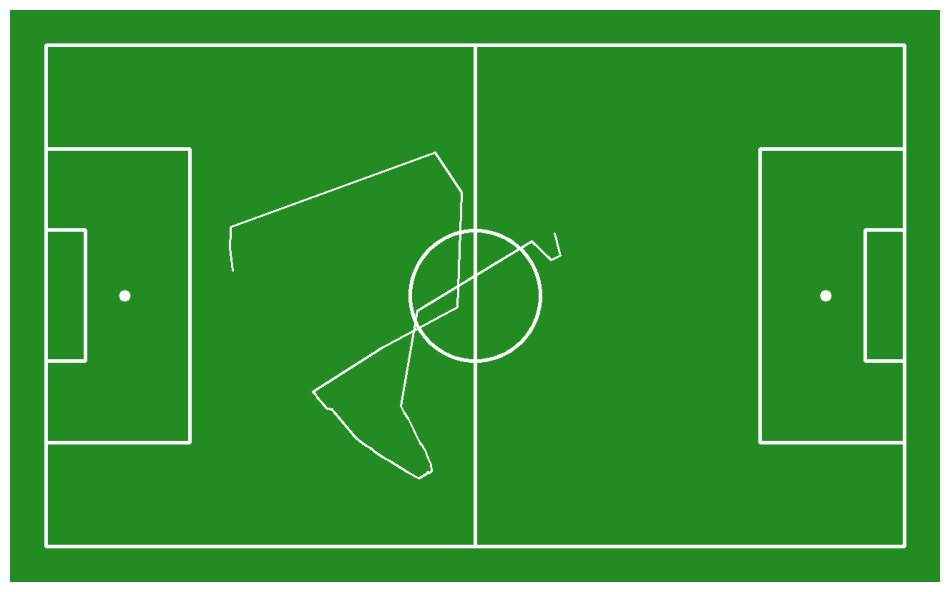

In [37]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [38]:
# from typing import List, Union
#
#
# def replace_outliers_based_on_distance(
#         positions: List[np.ndarray],
#         distance_threshold: float
# ) -> List[np.ndarray]:
#     last_valid_position: Union[np.ndarray, None] = None
#     cleaned_positions: List[np.ndarray] = []
#
#     for position in positions:
#         if len(position) == 0:
#             # If the current position is already empty, just add it to the cleaned positions
#             cleaned_positions.append(position)
#         else:
#             if last_valid_position is None:
#                 # If there's no valid last position, accept the first valid one
#                 cleaned_positions.append(position)
#                 last_valid_position = position
#             else:
#                 # Calculate the distance from the last valid position
#                 distance = np.linalg.norm(position - last_valid_position)
#                 if distance > distance_threshold:
#                     # Replace with empty array if the distance exceeds the threshold
#                     cleaned_positions.append(np.array([], dtype=np.float64))
#                 else:
#                     cleaned_positions.append(position)
#                     last_valid_position = position
#
#     return cleaned_positions


In [39]:
# MAX_DISTANCE_THRESHOLD = 500
#
# path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THRESHOLD)


In [40]:
# from sports.annotators.soccer import draw_paths_on_pitch
#
# annotated_frame = draw_pitch(CONFIG)
# annotated_frame = draw_paths_on_pitch(
#     config=CONFIG,
#     paths=[path],
#     color=sv.Color.WHITE,
#     pitch=annotated_frame)
#
# sv.plot_image(annotated_frame)

In [41]:
# Goal

